<a href="https://colab.research.google.com/github/Mateusz-best-creator/BitPredict-TensorFlow/blob/main/BitPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [147]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

**Note:** when working with time series problem, the word **window** mean: the amount of data we put into the model.

Also when working with time series data the ouput of a model is also often called the **horizon**.

# Time series forecasting fundamentals with TensorFlow + Milestone BitPredict project 💰

📓 In this notebook we are going to write TensorFlow code to predict the price of Bitcoin based on the historical price of bitcoin.

⚠ **Note:** this is not financial advice!

## Getting the data

We are going to be using the historical price data of bitcoin to try and predict the future price of Bitcoin, we downloaded the data from here: https://github.com/mrdbourke/tensorflow-deep-learning.

The updated data is also available here: https://www.coindesk.com/price/bitcoin/.

In [148]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-08-16 06:08:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2023-08-16 06:08:36 (6.00 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’ saved [178509/178509]



## Importing time series with data

In [149]:
# Read the bitcoin data and parse the dates
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"], # Parse the date column
                 index_col=["Date"]) # Set the date column as an index
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [151]:
# How many samples do we have
len(df)

2787

We have collected the historical price of Bitcoin for the past 8 years but there is only 2787 samples. Typically deep learning models likes lots of data (much more than 2787).

A smaller number of samples **is a common thing** when working with time series data problems.

**Note:** the **seasonality** of a time series dataset is referred to as the number of samples per year. So four our bitcoin data, it has seasonality of daily or value of 365, beacuse we collected one sample per day, meaning we will get 365 samples per year.

In [152]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.tail()

,Price
Date,
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255
2021-05-17,45604.615754
2021-05-18,43144.471291


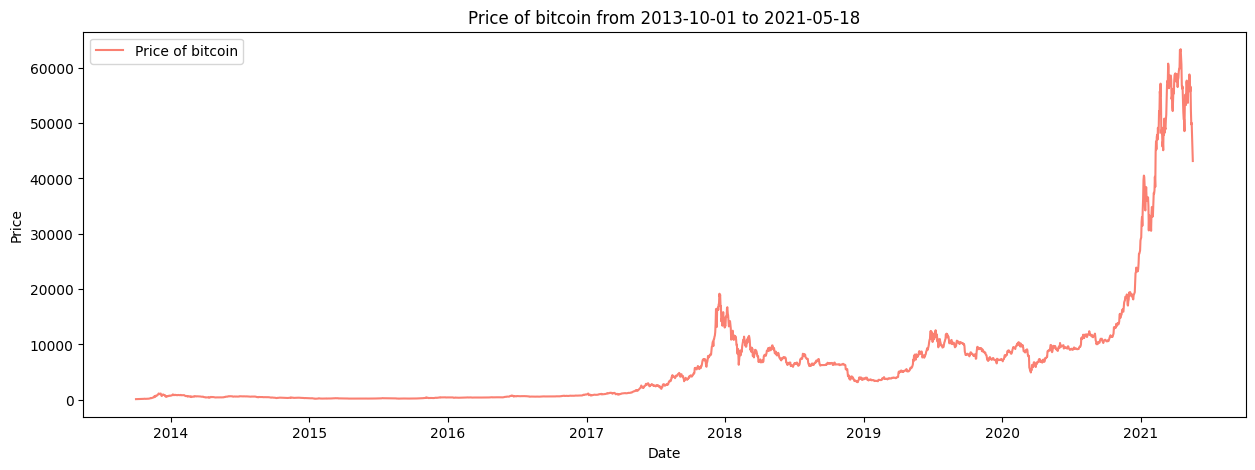

In [153]:
fig = plt.figure(figsize=(15, 5))
plt.plot(bitcoin_prices.index, bitcoin_prices["Price"], color="salmon", label="Price of bitcoin")
plt.xlabel("Date")
plt.title("Price of bitcoin from 2013-10-01 to 2021-05-18")
plt.legend()
plt.ylabel("Price");

## Read our CSV file with pure python

In [154]:
import csv

filename = "BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"
fields = []
rows = []

with open(filename) as f:
  csvreader = csv.reader(f)

  # Extracting fileds names from the first row
  fields = next(csvreader)

  # Extracting each data row one by one
  for row in csvreader:
    rows.append(row)

  print(f"Total number fo rows: {len(rows)}")
print(f"Fields in this dataset are:", ", ".join(field for field in fields))

# printing first 5 rows
print(f"\nFirst five rows are:\n")
for row in rows[:5]:
  for col in row:
    print("%10s"%col, end=" ")
  print("\n")

Total number fo rows: 2787
Fields in this dataset are: Currency, Date, Closing Price (USD), 24h Open (USD), 24h High (USD), 24h Low (USD)

First five rows are:

       BTC 2013-10-01  123.65499  124.30466  124.75166  122.56349 

       BTC 2013-10-02    125.455  123.65499   125.7585  123.63383 

       BTC 2013-10-03  108.58483    125.455  125.66566   83.32833 

       BTC 2013-10-04  118.67466  108.58483    118.675  107.05816 

       BTC 2013-10-05  121.33866  118.67466  121.93633  118.00566 



In [155]:
rows = np.array(rows)
prices = rows[:, 2].astype("float32")
dates = rows[:, 1].astype("datetime64")
bitcoin_df = pd.DataFrame({"Date": dates, "Price": prices}).set_index("Date")
bitcoin_df.tail()

,Price
Date,
2021-05-14,49764.132812
2021-05-15,50032.691406
2021-05-16,47885.625000
2021-05-17,45604.617188
2021-05-18,43144.472656


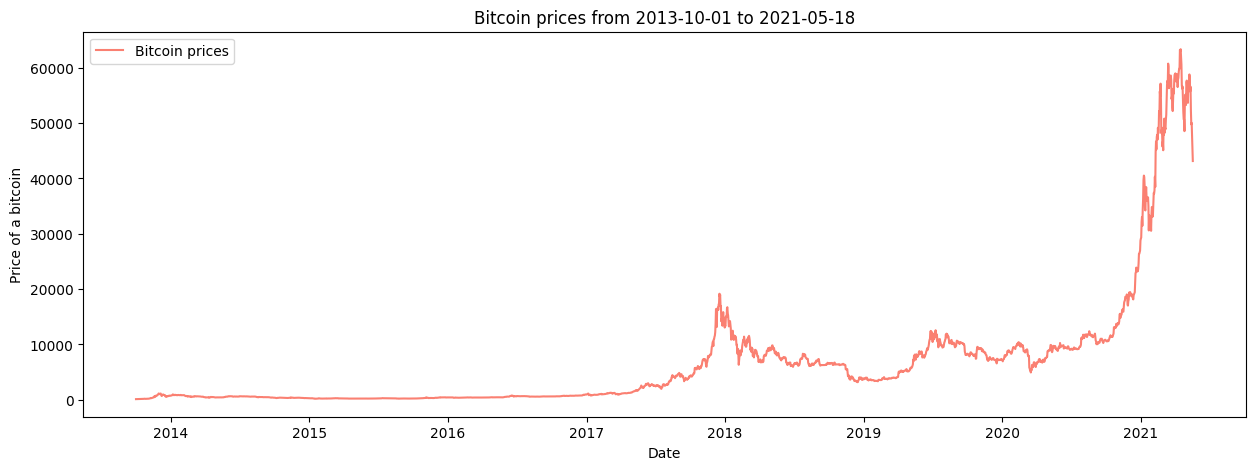

In [156]:
# Create same plot as above
fig = plt.figure(figsize=(15, 5))
plt.plot(bitcoin_df.index, bitcoin_df["Price"], color="salmon", label="Bitcoin prices")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price of a bitcoin")
plt.title("Bitcoin prices from 2013-10-01 to 2021-05-18");

## Format data part 1: Create train and test sets of our time series data.

### Create train and test sets with time series data (the wrong way)

In [157]:
timesteps = np.array(bitcoin_df.index)
bitcoin_prices = np.array(bitcoin_df["Price"])
timesteps[:5], bitcoin_prices[:5]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866],
       dtype=float32))

In [158]:
# Wrong way to make train, test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    bitcoin_prices,
                                                    test_size=0.1,
                                                    shuffle=True,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2508,), (279,), (2508,), (279,))

### Create plotting function

In [159]:
def plot_time_series_data(x_values, y_values, label, start=0, end=None, format="."):
  plt.plot(x_values[start:end], y_values[start:end], format, label=label)
  # Set annotations for labels
  plt.xlabel("Date")
  plt.ylabel("Bitcoin Price")
  plt.legend();

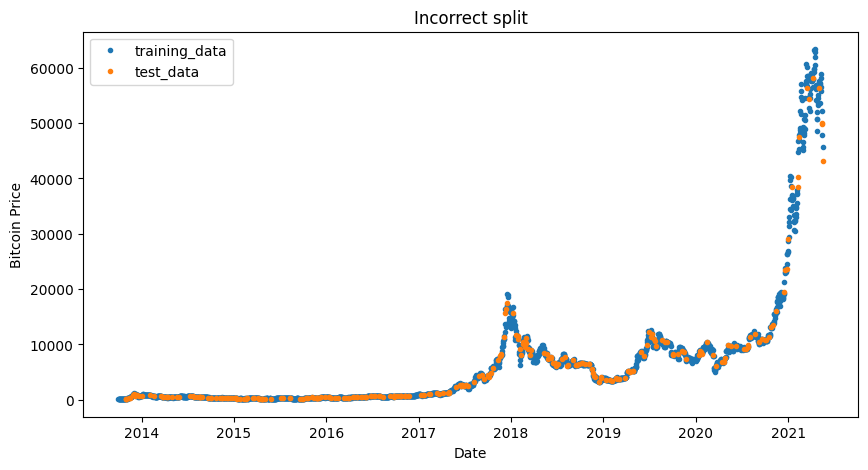

In [160]:
fig = plt.figure(figsize=(10, 5))
plot_time_series_data(X_train, y_train, "training_data")
plot_time_series_data(X_test, y_test, "test_data")
plt.title("Incorrect split");

### Create train and test sets with time series data (the right way)

In [161]:
split_size = int(0.8 * len(bitcoin_prices)) # 90% train data, 10% test data
# Create train, test datasets
X_train = timesteps[:split_size]
X_test = timesteps[split_size:]
y_train = bitcoin_prices[:split_size]
y_test = bitcoin_prices[split_size:]
# Check the shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

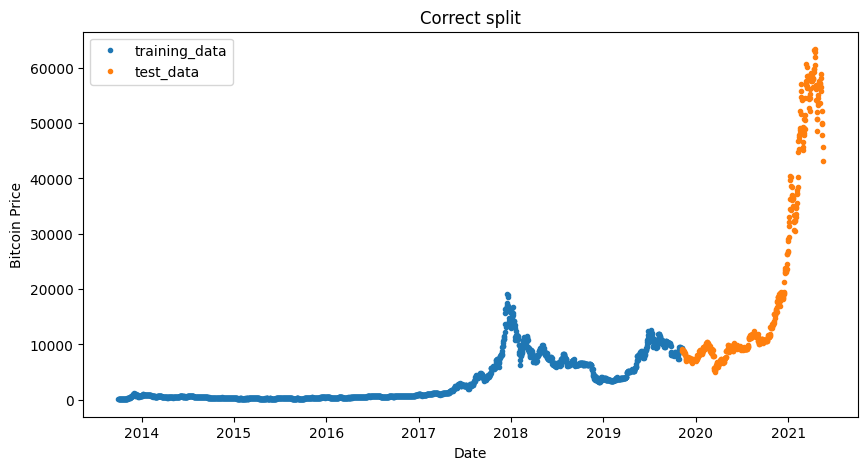

In [162]:
fig = plt.figure(figsize=(10, 5))
plot_time_series_data(X_train, y_train, "training_data")
plot_time_series_data(X_test, y_test, "test_data")
plt.title("Correct split");

# Start series of modelling experiments

We have some bitcoin historical data, to model it, we will run a series of modeling experiments and see which model performs best.

**Terms to be familiar with:**
* Horizon = number of timesteps into the future we are going to predict
* Window size = number of timesteps we are going to use to predict the **Horizon**.

Modelling experiments we are running:

| Model Number | Model Type | Horizon size | Window size | Extra data |
| ----- | ----- | ----- | ----- | ----- |
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA |
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (but with multivariate data) | 1 | 7 | Block reward size |
| 7 | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA |
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA|
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA |



## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}/_{t} = y_{t-1}$$

In words: the prediction at timestep t (y-hat) is equal to the value of timestep t-1 - this is for horizon of 1.

In [163]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[-10:], y_test[-10:] # View frist 10 and last 10

(array([57107.12 , 58788.21 , 58102.19 , 55715.547, 56573.555, 52147.82 ,
        49764.133, 50032.69 , 47885.625, 45604.617], dtype=float32),
 array([58788.21 , 58102.19 , 55715.547, 56573.555, 52147.82 , 49764.133,
        50032.69 , 47885.625, 45604.617, 43144.473], dtype=float32))

In [164]:
len(X_test), len(naive_forecast)

(558, 557)

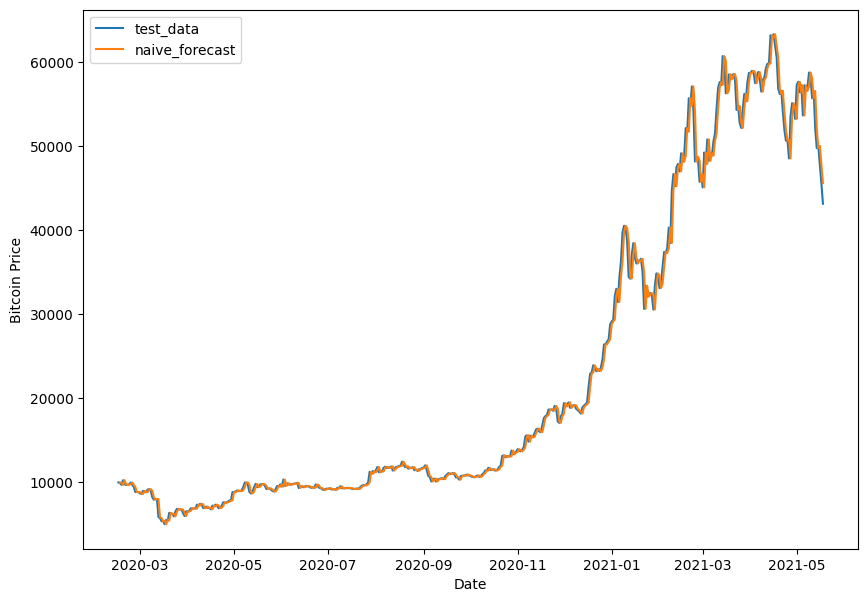

In [165]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
# plot_time_series_data(X_train, y_train, label="train_data")
plot_time_series_data(X_test, y_test, format="-", label="test_data", start=100)
plot_time_series_data(X_test[1:], naive_forecast, format="-", label="naive_forecast", start=100)

## Evaluating a time series model

Let's look on some evaluation metrics we can use for time series forecasting.

We are predicting a number, so that means we have form of regression problem.

Beacuse we are working on a regression problem we will need some typical regression metrics like:

* Mean absolute error (MAE)
* Mean squared error (MSE)
* Root mean squared error (RMSE)
* Mean absolute percentage error (MAPE)
* Mean absolute scaled error (MASE)

For all above metrics, **lower is better**.

The main thing we are evaluating here is: how do our model's forecasts (y_preds) compare against the actual values (y_true or ground truth labels).

For nice explanations: https://otexts.com/fpp3/accuracy.html

In [166]:
import tensorflow as tf

print(tf.__version__)

2.12.0


### Create functions to evaluate our model

In [167]:

# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [168]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [169]:
naive_results = evaluate_preds(y_test[1:], naive_forecast)
naive_results, naive_results["mase"].dtype

({'mae': 567.9802,
  'mse': 1147547.0,
  'rmse': 1071.2362,
  'mape': 2.5165248,
  'mase': 0.99957},
 dtype('float32'))

In [170]:
tf.reduce_max(y_test), tf.reduce_min(y_test)

(<tf.Tensor: shape=(), dtype=float32, numpy=63346.79>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4944.702>)

## Format data part 2: windowing our dataset

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [171]:
# What we want to do with our bitcoin data
print(f"What we want to use: {y_train[:7]}\nWhat we want to predict: {y_train[7]}")

What we want to use: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]
What we want to predict: 123.03299713134766


In [172]:
# Let's set global variables for window and horizon
HORIZON = 1 # predict the next 1 day
WINDOW_SIZE = 7 # use past 7 days to predict future day

### Create a function to label windowed data


In [173]:
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  If horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return (x[:, :-horizon], x[:, -horizon:])

In [174]:
tf.expand_dims(tf.range(8)+1, axis=0)

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7, 8]], dtype=int32)>

In [175]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0))
print(f"Test window: {test_window}\nTest labels: {test_label}")

Test window: [[1 2 3 4 5 6 7]]
Test labels: [[8]]


We have got a way to label our windowed data.

However, this only works on a small scale.

We need a way do for the above across our entire time series.

We could do this with Python for loops, however this will be quite slow.

To speed things up, we will leverage Numpy's array indexing.

Our function will:

1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6]).
2. It will use numpy indexing to create a 2D array of multiple window steps.
```
[
  [0, 1, 2, 3, 4, 5, 6],
  [1, 2, 3, 4, 5, 6, 7],
  [2, 3, 4, 5, 6, 7, 8],
]
```
3. Uses the 2D array of multiple window steps (from step 2.) to index on a target series (e.g. the historical price of bitcoin)
3. Uses our `get_labelled_windows` function we created above to turn the window steps into windows with a specific horizon.

In [176]:
# Create function to view Numpy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows
  of window_size with horizon size labels.
  """
  # 1.
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)
  # 2.
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=-1)
  # 3.
  windowed_array = x[window_indexes]
  # 4.
  windows, labels = get_labelled_windows(windowed_array, horizon=HORIZON)
  return windows, labels

In [177]:
full_windows, full_labels = make_windows(prices)
full_windows.shape, full_labels.shape

((2780, 7), (2780, 1))

In [178]:
# View the first 3 windows and labels
for i in range(3):
  print(f"Window: {full_windows[i]}, label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ], label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ], label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ], label: [125.96116]


In [179]:
# View the last 3 windows and labels
for i in range(3):
  print(f"Index: {i - 3}")
  print(f"Window: {full_windows[i - 3]}, label: {full_labels[i - 3]}")

Index: -3
Window: [58788.21  58102.19  55715.547 56573.555 52147.82  49764.133 50032.69 ], label: [47885.625]
Index: -2
Window: [58102.19  55715.547 56573.555 52147.82  49764.133 50032.69  47885.625], label: [45604.617]
Index: -1
Window: [55715.547 56573.555 52147.82  49764.133 50032.69  47885.625 45604.617], label: [43144.473]


## Turning windows into train and test sets

In [180]:
full_windows[:5], full_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]], dtype=float32),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]], dtype=float32))

In [181]:
# Make train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  splits_size = int(len(labels) * (1 - test_split)) # 80% train, 20% test
  train_windows, train_labels = windows[:splits_size], labels[:splits_size]
  test_windows, test_labels = windows[splits_size:], labels[splits_size:]

  print(f"""
  Training data : {train_windows.shape}, {train_labels.shape}\n
  Test data: {test_windows.shape}, {test_labels.shape}
  """)

  return train_windows, test_windows, train_labels, test_labels

In [182]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)


  Training data : (2224, 7), (2224, 1)

  Test data: (556, 7), (556, 1)
  


In [183]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]], dtype=float32),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]], dtype=float32))

## Make a modeling checkpoint callback





In [184]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Model 1: Dense model (window=7, horizon=1)

Our first model is going to be a simple dense model, it's going to have:

* A single dense layer with 128 hidden units and ReLU activation.
* An output layer with linear activation (no activation since we are predicting number).
* Adam optimizer and MAE loss function.
* Batch size of 128.
* Run this model for 100 epochs.

Since we dont have too much data (common thing when working with time series data) we can increase batch_size and number of epochs.

In [185]:
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 565.5574 - mae: 565.5574   

18/18 [==============================] - 3s 92ms/step - loss: 558.0328 - mae: 558.0328 - val_loss: 1173.2939 - val_mae: 1173.2939
Epoch 2/100
12/18 [===================>..........] - ETA: 0s - loss: 237.8908 - mae: 237.8908

18/18 [==============================] - 2s 140ms/step - loss: 232.0468 - mae: 232.0468 - val_loss: 1157.1173 - val_mae: 1157.1173
Epoch 3/100
14/18 [======================>.......] - ETA: 0s - loss: 196.4995 - mae: 196.4995

18/18 [==============================] - 1s 65ms/step - loss: 195.7553 - mae: 195.7553 - val_loss: 1131.7834 - val_mae: 1131.7834
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 242.0916 - mae: 242.0916

18/18 [==============================] - 1s 73ms/step - loss: 187.8978 - mae: 187.8978 - val_loss: 1080.7496 - val_mae: 1080.7496
Epoch 5/100
13/18 [====================>.........] - ETA: 0s - loss: 189.6513 - mae: 189.6513

18/18 [==============================] - 1s 68ms/step - loss: 184.3971 - mae: 184.3971 - val_loss: 997.8585 - val_mae: 997.8585
Epoch 6/100
17/18 [===========================>..] - ETA: 0s - loss: 179.8746 - mae: 179.8746

18/18 [==============================] - 2s 94ms/step - loss: 181.6220 - mae: 181.6220 - val_loss: 967.5002 - val_mae: 967.5002
Epoch 7/100
16/18 [=========================>....] - ETA: 0s - loss: 175.4597 - mae: 175.4597

18/18 [==============================] - 1s 68ms/step - loss: 170.5972 - mae: 170.5972 - val_loss: 925.8680 - val_mae: 925.8680
Epoch 8/100
18/18 [==============================] - ETA: 0s - loss: 164.4450 - mae: 164.4450

18/18 [==============================] - 3s 152ms/step - loss: 164.4450 - mae: 164.4450 - val_loss: 895.6431 - val_mae: 895.6431
Epoch 9/100
14/18 [======================>.......] - ETA: 0s - loss: 157.1555 - mae: 157.1555

18/18 [==============================] - 1s 76ms/step - loss: 160.3242 - mae: 160.3242 - val_loss: 872.4125 - val_mae: 872.4125
Epoch 10/100
16/18 [=========================>....] - ETA: 0s - loss: 152.9405 - mae: 152.9405

18/18 [==============================] - 1s 74ms/step - loss: 154.6446 - mae: 154.6446 - val_loss: 840.0829 - val_mae: 840.0829
Epoch 11/100
15/18 [========================>.....] - ETA: 0s - loss: 150.4426 - mae: 150.4426

18/18 [==============================] - 1s 80ms/step - loss: 149.1160 - mae: 149.1160 - val_loss: 832.1118 - val_mae: 832.1118
Epoch 12/100
18/18 [==============================] - 0s 13ms/step - loss: 145.6801 - mae: 145.6801 - val_loss: 889.1208 - val_mae: 889.1208
Epoch 13/100
11/18 [=================>............] - ETA: 0s - loss: 141.1901 - mae: 141.1901

18/18 [==============================] - 2s 110ms/step - loss: 146.2591 - mae: 146.2591 - val_loss: 813.6194 - val_mae: 813.6194
Epoch 14/100
17/18 [===========================>..] - ETA: 0s - loss: 135.9829 - mae: 135.9829

18/18 [==============================] - 2s 92ms/step - loss: 138.8867 - mae: 138.8867 - val_loss: 805.0795 - val_mae: 805.0795
Epoch 15/100
18/18 [==============================] - ETA: 0s - loss: 137.6479 - mae: 137.6479

18/18 [==============================] - 1s 60ms/step - loss: 137.6479 - mae: 137.6479 - val_loss: 731.3040 - val_mae: 731.3040
Epoch 16/100
18/18 [==============================] - 0s 4ms/step - loss: 131.5946 - mae: 131.5946 - val_loss: 731.4199 - val_mae: 731.4199
Epoch 17/100
18/18 [==============================] - 0s 5ms/step - loss: 129.6098 - mae: 129.6098 - val_loss: 750.1064 - val_mae: 750.1064
Epoch 18/100
16/18 [=========================>....] - ETA: 0s - loss: 130.5578 - mae: 130.5578

18/18 [==============================] - 1s 49ms/step - loss: 127.3948 - mae: 127.3948 - val_loss: 690.5975 - val_mae: 690.5975
Epoch 19/100
18/18 [==============================] - 0s 9ms/step - loss: 126.0408 - mae: 126.0408 - val_loss: 694.3697 - val_mae: 694.3697
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 138.8141 - mae: 138.8141

18/18 [==============================] - 1s 59ms/step - loss: 122.4027 - mae: 122.4027 - val_loss: 671.9892 - val_mae: 671.9892
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 138.7997 - mae: 138.7997

18/18 [==============================] - 2s 93ms/step - loss: 124.9816 - mae: 124.9816 - val_loss: 668.9205 - val_mae: 668.9205
Epoch 22/100
18/18 [==============================] - 0s 11ms/step - loss: 124.0285 - mae: 124.0285 - val_loss: 674.3371 - val_mae: 674.3371
Epoch 23/100
17/18 [===========================>..] - ETA: 0s - loss: 124.1827 - mae: 124.1827

18/18 [==============================] - 1s 85ms/step - loss: 125.2566 - mae: 125.2566 - val_loss: 644.9848 - val_mae: 644.9848
Epoch 24/100
13/18 [====================>.........] - ETA: 0s - loss: 123.2363 - mae: 123.2363

18/18 [==============================] - 1s 81ms/step - loss: 120.7817 - mae: 120.7817 - val_loss: 644.9471 - val_mae: 644.9471
Epoch 25/100
16/18 [=========================>....] - ETA: 0s - loss: 122.4018 - mae: 122.4018

18/18 [==============================] - 2s 95ms/step - loss: 119.1960 - mae: 119.1960 - val_loss: 631.9428 - val_mae: 631.9428
Epoch 26/100
18/18 [==============================] - 0s 5ms/step - loss: 117.4415 - mae: 117.4415 - val_loss: 639.6591 - val_mae: 639.6591
Epoch 27/100
18/18 [==============================] - 0s 6ms/step - loss: 119.0419 - mae: 119.0419 - val_loss: 647.1378 - val_mae: 647.1378
Epoch 28/100
16/18 [=========================>....] - ETA: 0s - loss: 115.8468 - mae: 115.8468

18/18 [==============================] - 1s 56ms/step - loss: 116.4686 - mae: 116.4686 - val_loss: 620.3055 - val_mae: 620.3055
Epoch 29/100
16/18 [=========================>....] - ETA: 0s - loss: 114.2220 - mae: 114.2220

18/18 [==============================] - 1s 69ms/step - loss: 115.0588 - mae: 115.0588 - val_loss: 616.1163 - val_mae: 616.1163
Epoch 30/100
13/18 [====================>.........] - ETA: 0s - loss: 120.0302 - mae: 120.0302

18/18 [==============================] - 1s 67ms/step - loss: 120.5388 - mae: 120.5388 - val_loss: 607.5153 - val_mae: 607.5153
Epoch 31/100
18/18 [==============================] - ETA: 0s - loss: 113.2125 - mae: 113.2125

18/18 [==============================] - 1s 43ms/step - loss: 113.2125 - mae: 113.2125 - val_loss: 603.7292 - val_mae: 603.7292
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 112.7721 - mae: 112.7721 - val_loss: 604.4427 - val_mae: 604.4427
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 115.6258 - mae: 115.6258 - val_loss: 656.9167 - val_mae: 656.9167
Epoch 34/100
18/18 [==============================] - 0s 5ms/step - loss: 114.6419 - mae: 114.6419 - val_loss: 615.5225 - val_mae: 615.5225
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 113.4461 - mae: 113.4461 - val_loss: 624.3989 - val_mae: 624.3989
Epoch 36/100
 1/18 [>.............................] - ETA: 0s - loss: 158.8930 - mae: 158.8930

18/18 [==============================] - 1s 36ms/step - loss: 113.7646 - mae: 113.7646 - val_loss: 592.1641 - val_mae: 592.1641
Epoch 37/100
18/18 [==============================] - 0s 5ms/step - loss: 111.0525 - mae: 111.0525 - val_loss: 593.3096 - val_mae: 593.3096
Epoch 38/100
18/18 [==============================] - 0s 5ms/step - loss: 112.7688 - mae: 112.7688 - val_loss: 600.3615 - val_mae: 600.3615
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 129.9230 - mae: 129.9230

18/18 [==============================] - 1s 37ms/step - loss: 111.1507 - mae: 111.1507 - val_loss: 591.6555 - val_mae: 591.6555
Epoch 40/100
18/18 [==============================] - 0s 8ms/step - loss: 110.5497 - mae: 110.5497 - val_loss: 623.3882 - val_mae: 623.3882
Epoch 41/100
16/18 [=========================>....] - ETA: 0s - loss: 112.9742 - mae: 112.9742

18/18 [==============================] - 1s 57ms/step - loss: 110.9154 - mae: 110.9154 - val_loss: 586.0817 - val_mae: 586.0817
Epoch 42/100
18/18 [==============================] - 0s 6ms/step - loss: 112.5724 - mae: 112.5724 - val_loss: 653.7672 - val_mae: 653.7672
Epoch 43/100
18/18 [==============================] - 0s 6ms/step - loss: 112.9289 - mae: 112.9289 - val_loss: 662.3090 - val_mae: 662.3090
Epoch 44/100
18/18 [==============================] - 0s 6ms/step - loss: 115.8731 - mae: 115.8731 - val_loss: 625.1550 - val_mae: 625.1550
Epoch 45/100
18/18 [==============================] - 0s 6ms/step - loss: 113.1777 - mae: 113.1777 - val_loss: 654.9658 - val_mae: 654.9658
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 96.0262 - mae: 96.0262

18/18 [==============================] - 1s 53ms/step - loss: 112.1049 - mae: 112.1049 - val_loss: 578.4067 - val_mae: 578.4067
Epoch 47/100
18/18 [==============================] - 0s 6ms/step - loss: 108.8366 - mae: 108.8366 - val_loss: 640.9291 - val_mae: 640.9291
Epoch 48/100
18/18 [==============================] - 0s 4ms/step - loss: 109.4721 - mae: 109.4721 - val_loss: 591.8320 - val_mae: 591.8320
Epoch 49/100
18/18 [==============================] - 0s 6ms/step - loss: 111.4101 - mae: 111.4101 - val_loss: 680.6334 - val_mae: 680.6334
Epoch 50/100
18/18 [==============================] - 0s 9ms/step - loss: 119.2991 - mae: 119.2991 - val_loss: 642.0709 - val_mae: 642.0709
Epoch 51/100
18/18 [==============================] - 0s 7ms/step - loss: 111.7161 - mae: 111.7161 - val_loss: 604.2683 - val_mae: 604.2683
Epoch 52/100
18/18 [==============================] - 0s 8ms/step - loss: 115.3287 - mae: 115.3287 - val_loss: 634.9965 - val_mae: 634.9965
Epoch 53/100
18/18 [============

18/18 [==============================] - 1s 57ms/step - loss: 110.6437 - mae: 110.6437 - val_loss: 575.1162 - val_mae: 575.1162
Epoch 55/100
 1/18 [>.............................] - ETA: 0s - loss: 126.4904 - mae: 126.4904

18/18 [==============================] - 1s 48ms/step - loss: 108.1358 - mae: 108.1358 - val_loss: 574.7498 - val_mae: 574.7498
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 107.0261 - mae: 107.0261 - val_loss: 735.5159 - val_mae: 735.5159
Epoch 57/100
18/18 [==============================] - 0s 6ms/step - loss: 111.3257 - mae: 111.3257 - val_loss: 586.2447 - val_mae: 586.2447
Epoch 58/100
15/18 [========================>.....] - ETA: 0s - loss: 107.5460 - mae: 107.5460

18/18 [==============================] - 1s 54ms/step - loss: 106.9751 - mae: 106.9751 - val_loss: 573.3788 - val_mae: 573.3788
Epoch 59/100
18/18 [==============================] - 0s 7ms/step - loss: 107.0962 - mae: 107.0962 - val_loss: 616.8073 - val_mae: 616.8073
Epoch 60/100
18/18 [==============================] - 0s 8ms/step - loss: 111.1130 - mae: 111.1130 - val_loss: 597.2780 - val_mae: 597.2780
Epoch 61/100
18/18 [==============================] - 0s 7ms/step - loss: 107.8121 - mae: 107.8121 - val_loss: 586.6902 - val_mae: 586.6902
Epoch 62/100
16/18 [=========================>....] - ETA: 0s - loss: 110.6931 - mae: 110.6931

18/18 [==============================] - 1s 62ms/step - loss: 108.5501 - mae: 108.5501 - val_loss: 573.0080 - val_mae: 573.0080
Epoch 63/100
18/18 [==============================] - 0s 10ms/step - loss: 107.9982 - mae: 107.9982 - val_loss: 583.9531 - val_mae: 583.9531
Epoch 64/100
18/18 [==============================] - 0s 8ms/step - loss: 107.3893 - mae: 107.3893 - val_loss: 617.8759 - val_mae: 617.8759
Epoch 65/100
 1/18 [>.............................] - ETA: 0s - loss: 134.0942 - mae: 134.0942

18/18 [==============================] - 2s 95ms/step - loss: 109.5639 - mae: 109.5639 - val_loss: 570.4316 - val_mae: 570.4316
Epoch 66/100
18/18 [==============================] - 0s 4ms/step - loss: 107.3450 - mae: 107.3450 - val_loss: 579.2751 - val_mae: 579.2751
Epoch 67/100
18/18 [==============================] - 0s 4ms/step - loss: 107.1544 - mae: 107.1544 - val_loss: 651.3123 - val_mae: 651.3123
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 105.8841 - mae: 105.8841 - val_loss: 583.4059 - val_mae: 583.4059
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 108.1150 - mae: 108.1150 - val_loss: 653.5136 - val_mae: 653.5136
Epoch 70/100
18/18 [==============================] - 0s 4ms/step - loss: 119.6090 - mae: 119.6090 - val_loss: 641.6827 - val_mae: 641.6827
Epoch 71/100
18/18 [==============================] - 0s 4ms/step - loss: 108.5259 - mae: 108.5259 - val_loss: 571.8716 - val_mae: 571.8716
Epoch 72/100
18/18 [============

18/18 [==============================] - 1s 46ms/step - loss: 110.7469 - mae: 110.7469 - val_loss: 567.4623 - val_mae: 567.4623
Epoch 80/100
18/18 [==============================] - 0s 7ms/step - loss: 106.2970 - mae: 106.2970 - val_loss: 569.7971 - val_mae: 569.7971
Epoch 81/100
18/18 [==============================] - 0s 8ms/step - loss: 105.4646 - mae: 105.4646 - val_loss: 573.1531 - val_mae: 573.1531
Epoch 82/100
18/18 [==============================] - 0s 10ms/step - loss: 116.2939 - mae: 116.2939 - val_loss: 593.8792 - val_mae: 593.8792
Epoch 83/100
18/18 [==============================] - 0s 10ms/step - loss: 117.5595 - mae: 117.5595 - val_loss: 670.0280 - val_mae: 670.0280
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 114.2855 - mae: 114.2855 - val_loss: 579.5090 - val_mae: 579.5090
Epoch 85/100
18/18 [==============================] - 0s 9ms/step - loss: 108.5904 - mae: 108.5904 - val_loss: 569.2609 - val_mae: 569.2609
Epoch 86/100
18/18 [==========

18/18 [==============================] - 1s 83ms/step - loss: 109.3175 - mae: 109.3175 - val_loss: 565.9127 - val_mae: 565.9127
Epoch 100/100
18/18 [==============================] - 0s 12ms/step - loss: 105.9625 - mae: 105.9625 - val_loss: 568.2896 - val_mae: 568.2896


In [186]:
# Evaluate model on the test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.2896 - mae: 568.2896


[568.28955078125, 568.28955078125]

In [187]:
# Load in the saved best performing model and evaluate it on the test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 565.9126 - mae: 565.9126


[565.91259765625, 565.91259765625]

## Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they are only pseudo forecasts beacuse actual foreacts are into the future). Let's write a function to:

1. Take in a trained model.
2. Takes in some input data (same kind of data that our model was trained on).
3. Passes input data to model's predict method.
4. Return results.

In [188]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data.
  """
  pseudo_forecast = model.predict(input_data)
  return tf.squeeze(pseudo_forecast) # Return 1D array of predictions

In [189]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10], test_labels[:10]

18/18 [==============================] - 0s 5ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8837.358, 8760.101, 9025.011, 8785.494, 8733.325, 8716.993,
        8679.502, 8507.6  , 8447.735, 8519.156], dtype=float32)>,
 array([[8798.042 ],
        [9081.187 ],
        [8711.534 ],
        [8760.893 ],
        [8749.5205],
        [8656.971 ],
        [8500.644 ],
        [8469.261 ],
        [8537.34  ],
        [8205.807 ]], dtype=float32))

In [190]:
model_1_results = evaluate_preds(test_labels.reshape(-1), model_1_preds)
model_1_results

{'mae': 565.9127,
 'mse': 1161480.8,
 'rmse': 1077.7202,
 'mape': 2.5482464,
 'mase': 0.9941519}

In [191]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

In [192]:
test_labels.shape, -len(test_windows)

((556, 1), -556)

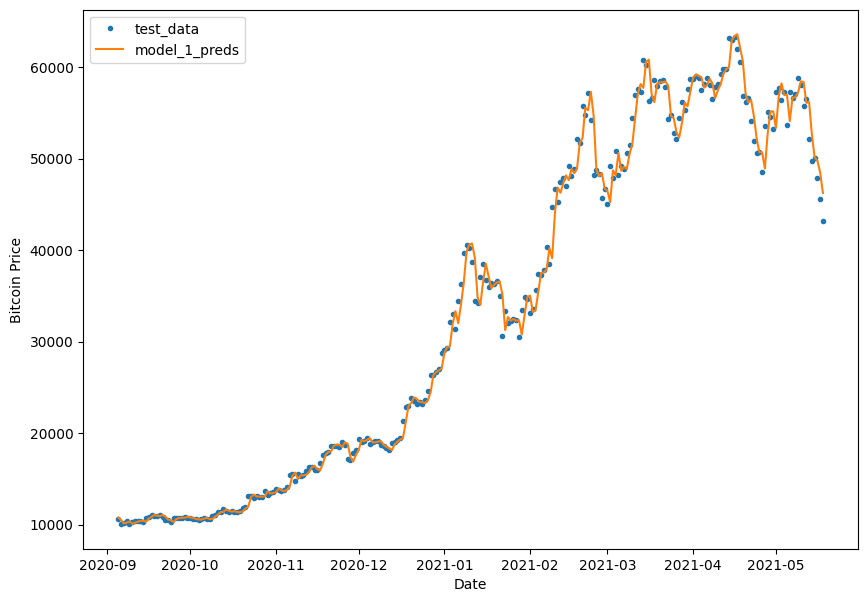

In [193]:
# Let's plot our model_1 predictions
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test window offset and index into test_labels to ensure correct plotting
plot_time_series_data(X_test[-len(test_windows):], test_labels[:, 0], start=offset, label="test_data")
# Plot model_1 predictions
plot_time_series_data(X_test[-len(test_windows):],
                      model_1_preds,
                      start=offset, format="-",
                      label="model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)

In [194]:
HORIZON = 1 # Predict one step at a time
WINDOW_SIZE = 30 # Use last 30 timesteps to predict future value

In [195]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [196]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split=0.2)


  Training data : (2205, 30), (2205, 1)

  Test data: (552, 30), (552, 1)
  


In [197]:
train_windows[:1], train_labels[:1]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20332, 142.76334, 137.92332, 142.95166,
         152.55183, 160.33884, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15984, 192.75665, 197.4    ]],
       dtype=float32),
 array([[196.025]], dtype=float32))

In [198]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1)
], name="model_2_dense")
# Compile the model
model_2.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])
# Train a model
history_2 = model_2.fit(train_windows, train_labels, epochs=100, batch_size=128,
                        validation_data=(test_windows, test_labels),
                        callbacks=[create_model_checkpoint(model_2.name)])

Epoch 1/100
16/18 [=========================>....] - ETA: 0s - loss: 10064.1650 - mae: 10064.1650 

18/18 [==============================] - 3s 124ms/step - loss: 9401.1719 - mae: 9401.1719 - val_loss: 8825.3789 - val_mae: 8825.3789
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 2006.0055 - mae: 2006.0055 - val_loss: 9185.8125 - val_mae: 9185.8125
Epoch 3/100
15/18 [========================>.....] - ETA: 0s - loss: 828.0142 - mae: 828.0142  

18/18 [==============================] - 1s 82ms/step - loss: 797.7856 - mae: 797.7856 - val_loss: 3864.7097 - val_mae: 3864.7097
Epoch 4/100
17/18 [===========================>..] - ETA: 0s - loss: 478.2463 - mae: 478.2463

18/18 [==============================] - 1s 63ms/step - loss: 482.5826 - mae: 482.5826 - val_loss: 2171.9888 - val_mae: 2171.9888
Epoch 5/100
17/18 [===========================>..] - ETA: 0s - loss: 392.2875 - mae: 392.2875

18/18 [==============================] - 1s 80ms/step - loss: 393.2717 - mae: 393.2717 - val_loss: 1939.9807 - val_mae: 1939.9807
Epoch 6/100
12/18 [===================>..........] - ETA: 0s - loss: 362.5228 - mae: 362.5228

18/18 [==============================] - 2s 118ms/step - loss: 355.6699 - mae: 355.6699 - val_loss: 1927.2839 - val_mae: 1927.2839
Epoch 7/100
16/18 [=========================>....] - ETA: 0s - loss: 317.3369 - mae: 317.3369

18/18 [==============================] - 2s 100ms/step - loss: 313.2670 - mae: 313.2670 - val_loss: 1532.1857 - val_mae: 1532.1857
Epoch 8/100
11/18 [=================>............] - ETA: 0s - loss: 275.9379 - mae: 275.9379

18/18 [==============================] - 2s 93ms/step - loss: 275.6740 - mae: 275.6740 - val_loss: 1527.5535 - val_mae: 1527.5535
Epoch 9/100
12/18 [===================>..........] - ETA: 0s - loss: 274.2062 - mae: 274.2062

18/18 [==============================] - 1s 56ms/step - loss: 253.6540 - mae: 253.6540 - val_loss: 1295.6144 - val_mae: 1295.6144
Epoch 10/100
18/18 [==============================] - 0s 5ms/step - loss: 237.4685 - mae: 237.4685 - val_loss: 1502.4016 - val_mae: 1502.4016
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 279.8883 - mae: 279.8883

18/18 [==============================] - 1s 49ms/step - loss: 268.3873 - mae: 268.3873 - val_loss: 1211.8188 - val_mae: 1211.8188
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 247.8768 - mae: 247.8768 - val_loss: 1313.3752 - val_mae: 1313.3752
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 219.4435 - mae: 219.4435

18/18 [==============================] - 1s 49ms/step - loss: 245.2762 - mae: 245.2762 - val_loss: 1132.3940 - val_mae: 1132.3940
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 274.6669 - mae: 274.6669

18/18 [==============================] - 1s 47ms/step - loss: 203.1902 - mae: 203.1902 - val_loss: 1078.1783 - val_mae: 1078.1783
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 261.0335 - mae: 261.0335

18/18 [==============================] - 1s 50ms/step - loss: 196.7515 - mae: 196.7515 - val_loss: 983.1960 - val_mae: 983.1960
Epoch 16/100
11/18 [=================>............] - ETA: 0s - loss: 187.1395 - mae: 187.1395

18/18 [==============================] - 1s 51ms/step - loss: 187.2445 - mae: 187.2445 - val_loss: 957.2706 - val_mae: 957.2706
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 114.8501 - mae: 114.8501

18/18 [==============================] - 1s 54ms/step - loss: 194.8136 - mae: 194.8136 - val_loss: 939.3587 - val_mae: 939.3587
Epoch 18/100
16/18 [=========================>....] - ETA: 0s - loss: 175.3652 - mae: 175.3652

18/18 [==============================] - 1s 65ms/step - loss: 182.1729 - mae: 182.1729 - val_loss: 911.6140 - val_mae: 911.6140
Epoch 19/100
18/18 [==============================] - 0s 8ms/step - loss: 178.9891 - mae: 178.9891 - val_loss: 983.8346 - val_mae: 983.8346
Epoch 20/100
18/18 [==============================] - 0s 8ms/step - loss: 181.5715 - mae: 181.5715 - val_loss: 919.9476 - val_mae: 919.9476
Epoch 21/100
18/18 [==============================] - 0s 21ms/step - loss: 187.7045 - mae: 187.7045 - val_loss: 960.0161 - val_mae: 960.0161
Epoch 22/100
17/18 [===========================>..] - ETA: 0s - loss: 216.4522 - mae: 216.4522

18/18 [==============================] - 3s 168ms/step - loss: 217.6202 - mae: 217.6202 - val_loss: 880.4324 - val_mae: 880.4324
Epoch 23/100
18/18 [==============================] - 0s 5ms/step - loss: 183.6521 - mae: 183.6521 - val_loss: 1339.9099 - val_mae: 1339.9099
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 293.3414 - mae: 293.3414

18/18 [==============================] - 1s 66ms/step - loss: 184.6950 - mae: 184.6950 - val_loss: 842.1218 - val_mae: 842.1218
Epoch 25/100
18/18 [==============================] - 0s 9ms/step - loss: 168.1517 - mae: 168.1517 - val_loss: 979.2806 - val_mae: 979.2806
Epoch 26/100
18/18 [==============================] - 0s 9ms/step - loss: 180.4059 - mae: 180.4059 - val_loss: 1028.6965 - val_mae: 1028.6965
Epoch 27/100
18/18 [==============================] - 0s 8ms/step - loss: 215.0280 - mae: 215.0280 - val_loss: 1079.7925 - val_mae: 1079.7925
Epoch 28/100
17/18 [===========================>..] - ETA: 0s - loss: 186.8439 - mae: 186.8439

18/18 [==============================] - 1s 72ms/step - loss: 185.5360 - mae: 185.5360 - val_loss: 812.3382 - val_mae: 812.3382
Epoch 29/100
18/18 [==============================] - 0s 7ms/step - loss: 177.1409 - mae: 177.1409 - val_loss: 994.3494 - val_mae: 994.3494
Epoch 30/100
18/18 [==============================] - 0s 8ms/step - loss: 163.2526 - mae: 163.2526 - val_loss: 965.0089 - val_mae: 965.0089
Epoch 31/100
18/18 [==============================] - 0s 9ms/step - loss: 182.1418 - mae: 182.1418 - val_loss: 1009.3604 - val_mae: 1009.3604
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 224.5752 - mae: 224.5752

18/18 [==============================] - 1s 81ms/step - loss: 185.1667 - mae: 185.1667 - val_loss: 807.0912 - val_mae: 807.0912
Epoch 33/100
17/18 [===========================>..] - ETA: 0s - loss: 160.8990 - mae: 160.8990

18/18 [==============================] - 4s 215ms/step - loss: 160.3256 - mae: 160.3256 - val_loss: 783.5340 - val_mae: 783.5340
Epoch 34/100
18/18 [==============================] - 0s 8ms/step - loss: 153.5478 - mae: 153.5478 - val_loss: 1105.5668 - val_mae: 1105.5668
Epoch 35/100
18/18 [==============================] - 0s 8ms/step - loss: 177.9834 - mae: 177.9834 - val_loss: 1212.6437 - val_mae: 1212.6437
Epoch 36/100
18/18 [==============================] - 0s 7ms/step - loss: 173.7075 - mae: 173.7075 - val_loss: 1255.6902 - val_mae: 1255.6902
Epoch 37/100
18/18 [==============================] - 0s 8ms/step - loss: 178.7268 - mae: 178.7268 - val_loss: 904.5215 - val_mae: 904.5215
Epoch 38/100
18/18 [==============================] - 0s 12ms/step - loss: 173.6990 - mae: 173.6990 - val_loss: 800.5650 - val_mae: 800.5650
Epoch 39/100
18/18 [==============================] - 0s 24ms/step - loss: 160.3526 - mae: 160.3526 - val_loss: 798.2864 - val_mae: 798.2864
Epoch 40/100
18/18 [===

18/18 [==============================] - 2s 114ms/step - loss: 146.1524 - mae: 146.1524 - val_loss: 773.2216 - val_mae: 773.2216
Epoch 44/100
18/18 [==============================] - 0s 8ms/step - loss: 166.7094 - mae: 166.7094 - val_loss: 793.2302 - val_mae: 793.2302
Epoch 45/100
18/18 [==============================] - 0s 9ms/step - loss: 152.2917 - mae: 152.2917 - val_loss: 868.1716 - val_mae: 868.1716
Epoch 46/100
14/18 [======================>.......] - ETA: 0s - loss: 147.8006 - mae: 147.8006

18/18 [==============================] - 3s 156ms/step - loss: 147.2656 - mae: 147.2656 - val_loss: 733.8780 - val_mae: 733.8780
Epoch 47/100
14/18 [======================>.......] - ETA: 0s - loss: 144.3226 - mae: 144.3226

18/18 [==============================] - 1s 78ms/step - loss: 143.7806 - mae: 143.7806 - val_loss: 728.5337 - val_mae: 728.5337
Epoch 48/100
14/18 [======================>.......] - ETA: 0s - loss: 134.4560 - mae: 134.4560

18/18 [==============================] - 1s 63ms/step - loss: 140.4943 - mae: 140.4943 - val_loss: 726.6064 - val_mae: 726.6064
Epoch 49/100
18/18 [==============================] - 0s 8ms/step - loss: 145.6064 - mae: 145.6064 - val_loss: 764.3400 - val_mae: 764.3400
Epoch 50/100
18/18 [==============================] - 0s 8ms/step - loss: 152.2130 - mae: 152.2130 - val_loss: 823.8088 - val_mae: 823.8088
Epoch 51/100
18/18 [==============================] - 0s 8ms/step - loss: 149.1193 - mae: 149.1193 - val_loss: 768.2341 - val_mae: 768.2341
Epoch 52/100
18/18 [==============================] - 0s 8ms/step - loss: 151.4492 - mae: 151.4492 - val_loss: 1026.9065 - val_mae: 1026.9065
Epoch 53/100
18/18 [==============================] - 0s 7ms/step - loss: 161.5713 - mae: 161.5713 - val_loss: 1610.8876 - val_mae: 1610.8876
Epoch 54/100
18/18 [==============================] - 0s 8ms/step - loss: 189.3217 - mae: 189.3217 - val_loss: 835.9779 - val_mae: 835.9779
Epoch 55/100
18/18 [========

18/18 [==============================] - 1s 72ms/step - loss: 141.0342 - mae: 141.0342 - val_loss: 725.3911 - val_mae: 725.3911
Epoch 57/100
18/18 [==============================] - 0s 8ms/step - loss: 145.7834 - mae: 145.7834 - val_loss: 1065.4366 - val_mae: 1065.4366
Epoch 58/100
18/18 [==============================] - 0s 8ms/step - loss: 170.2541 - mae: 170.2541 - val_loss: 732.6957 - val_mae: 732.6957
Epoch 59/100
18/18 [==============================] - 0s 9ms/step - loss: 174.0206 - mae: 174.0206 - val_loss: 1005.2370 - val_mae: 1005.2370
Epoch 60/100
18/18 [==============================] - 0s 7ms/step - loss: 152.4317 - mae: 152.4317 - val_loss: 769.1833 - val_mae: 769.1833
Epoch 61/100
18/18 [==============================] - 0s 9ms/step - loss: 131.2997 - mae: 131.2997 - val_loss: 735.4279 - val_mae: 735.4279
Epoch 62/100
18/18 [==============================] - 0s 7ms/step - loss: 130.2248 - mae: 130.2248 - val_loss: 758.9520 - val_mae: 758.9520
Epoch 63/100
18/18 [========

18/18 [==============================] - 1s 56ms/step - loss: 139.7735 - mae: 139.7735 - val_loss: 689.2565 - val_mae: 689.2565
Epoch 66/100
18/18 [==============================] - 0s 6ms/step - loss: 138.8335 - mae: 138.8335 - val_loss: 730.5532 - val_mae: 730.5532
Epoch 67/100
18/18 [==============================] - 0s 13ms/step - loss: 133.9824 - mae: 133.9824 - val_loss: 740.1085 - val_mae: 740.1085
Epoch 68/100
13/18 [====================>.........] - ETA: 0s - loss: 130.3233 - mae: 130.3233

18/18 [==============================] - 2s 120ms/step - loss: 132.1551 - mae: 132.1551 - val_loss: 686.2337 - val_mae: 686.2337
Epoch 69/100
18/18 [==============================] - 0s 13ms/step - loss: 135.7499 - mae: 135.7499 - val_loss: 913.5457 - val_mae: 913.5457
Epoch 70/100
18/18 [==============================] - 0s 7ms/step - loss: 147.6531 - mae: 147.6531 - val_loss: 712.4747 - val_mae: 712.4747
Epoch 71/100
17/18 [===========================>..] - ETA: 0s - loss: 132.9849 - mae: 132.9849

18/18 [==============================] - 1s 68ms/step - loss: 132.1560 - mae: 132.1560 - val_loss: 681.2583 - val_mae: 681.2583
Epoch 72/100
18/18 [==============================] - 0s 9ms/step - loss: 128.0673 - mae: 128.0673 - val_loss: 821.0216 - val_mae: 821.0216
Epoch 73/100
18/18 [==============================] - 0s 8ms/step - loss: 132.6894 - mae: 132.6894 - val_loss: 796.7512 - val_mae: 796.7512
Epoch 74/100
18/18 [==============================] - 0s 8ms/step - loss: 135.6852 - mae: 135.6852 - val_loss: 752.3759 - val_mae: 752.3759
Epoch 75/100
18/18 [==============================] - 0s 8ms/step - loss: 138.1143 - mae: 138.1143 - val_loss: 1223.4050 - val_mae: 1223.4050
Epoch 76/100
18/18 [==============================] - 0s 6ms/step - loss: 224.7770 - mae: 224.7770 - val_loss: 1416.4856 - val_mae: 1416.4856
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 173.5103 - mae: 173.5103 - val_loss: 704.6782 - val_mae: 704.6782
Epoch 78/100
18/18 [========

18/18 [==============================] - 1s 67ms/step - loss: 129.1972 - mae: 129.1972 - val_loss: 667.1971 - val_mae: 667.1971
Epoch 84/100
18/18 [==============================] - 0s 8ms/step - loss: 122.0758 - mae: 122.0758 - val_loss: 716.2102 - val_mae: 716.2102
Epoch 85/100
18/18 [==============================] - 0s 10ms/step - loss: 136.1766 - mae: 136.1766 - val_loss: 727.2504 - val_mae: 727.2504
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 139.2254 - mae: 139.2254 - val_loss: 804.7626 - val_mae: 804.7626
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 126.8955 - mae: 126.8955 - val_loss: 674.9569 - val_mae: 674.9569
Epoch 88/100
18/18 [==============================] - 0s 8ms/step - loss: 131.4953 - mae: 131.4953 - val_loss: 1004.0652 - val_mae: 1004.0652
Epoch 89/100
18/18 [==============================] - 0s 10ms/step - loss: 176.5333 - mae: 176.5333 - val_loss: 814.4019 - val_mae: 814.4019
Epoch 90/100
18/18 [========

18/18 [==============================] - 1s 52ms/step - loss: 122.7529 - mae: 122.7529 - val_loss: 657.7855 - val_mae: 657.7855
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 127.7705 - mae: 127.7705 - val_loss: 750.2954 - val_mae: 750.2954
Epoch 93/100
 1/18 [>.............................] - ETA: 0s - loss: 165.5547 - mae: 165.5547

18/18 [==============================] - 1s 36ms/step - loss: 142.2659 - mae: 142.2659 - val_loss: 656.0066 - val_mae: 656.0066
Epoch 94/100
18/18 [==============================] - 0s 5ms/step - loss: 134.2565 - mae: 134.2565 - val_loss: 895.1058 - val_mae: 895.1058
Epoch 95/100
18/18 [==============================] - 0s 5ms/step - loss: 153.7314 - mae: 153.7314 - val_loss: 957.5895 - val_mae: 957.5895
Epoch 96/100
18/18 [==============================] - 0s 7ms/step - loss: 152.9353 - mae: 152.9353 - val_loss: 1015.6774 - val_mae: 1015.6774
Epoch 97/100
18/18 [==============================] - 0s 4ms/step - loss: 148.3013 - mae: 148.3013 - val_loss: 1054.6344 - val_mae: 1054.6344
Epoch 98/100
18/18 [==============================] - 0s 4ms/step - loss: 172.0410 - mae: 172.0410 - val_loss: 730.4354 - val_mae: 730.4354
Epoch 99/100
18/18 [==============================] - 0s 4ms/step - loss: 143.9023 - mae: 143.9023 - val_loss: 1393.8907 - val_mae: 1393.8907
Epoch 100/100
18/18 [=====

In [199]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense")

In [200]:
# Evaluate model_2
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 656.0066 - mae: 656.0066


[656.006591796875, 656.006591796875]

In [201]:
model_2_preds = make_preds(model_2, test_windows)
model_2_preds[:2]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([8797.304, 8873.425], dtype=float32)>

In [202]:
model_2_results = evaluate_preds(tf.squeeze(test_labels), model_2_preds)
model_2_results

{'mae': 656.00665,
 'mse': 1460278.2,
 'rmse': 1208.4197,
 'mape': 3.0594099,
 'mase': 1.146706}

In [203]:
model_1_results

{'mae': 565.9127,
 'mse': 1161480.8,
 'rmse': 1077.7202,
 'mape': 2.5482464,
 'mase': 0.9941519}

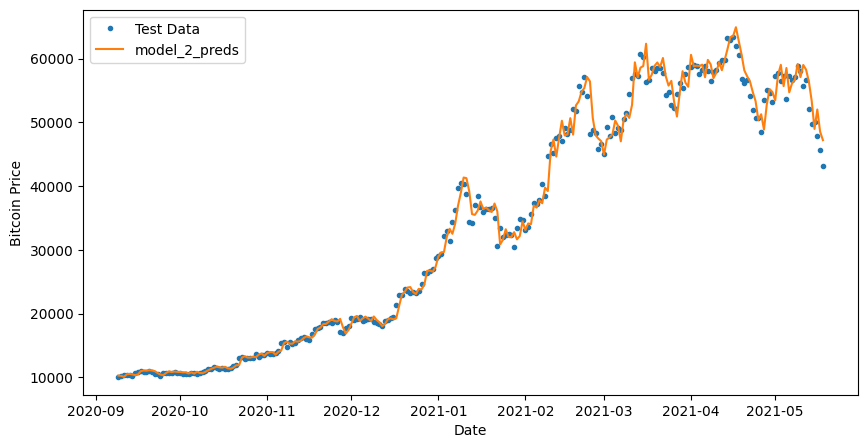

In [204]:
plt.figure(figsize=(10, 5))
offset = 300
# Account (raport) from test_window offset when plotting
plot_time_series_data(X_test[-len(test_windows):], test_labels[:, 0], start=offset, label="Test Data")
plot_time_series_data(X_test[-len(test_windows):], model_2_preds, start=offset, format="-", label="model_2_preds");

## Model 3: different HORIZON value

In [205]:
HORIZON = 7 # Predict one step at a time
WINDOW_SIZE = 30 # Use last 30 timesteps to predict future value

In [206]:
len(bitcoin_prices)

2787

In [207]:
full_windows, full_labels = make_windows(bitcoin_prices)

In [208]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split=0.2)


  Training data : (2224, 1), (2224, 7)

  Test data: (556, 1), (556, 7)
  


In [209]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(HORIZON)
], name="model_3_dense")
# Compile the model
model_3.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])
# Train a model
history_3 = model_3.fit(train_windows, train_labels, epochs=100, batch_size=128,
                        validation_data=(test_windows, test_labels),
                        callbacks=[create_model_checkpoint(model_3.name)])

Epoch 1/100
14/18 [======================>.......] - ETA: 0s - loss: 2303.8252 - mae: 2303.8252 

18/18 [==============================] - 5s 218ms/step - loss: 2130.0945 - mae: 2130.0945 - val_loss: 7088.6289 - val_mae: 7088.6289
Epoch 2/100
12/18 [===================>..........] - ETA: 0s - loss: 986.1229 - mae: 986.1229

18/18 [==============================] - 1s 65ms/step - loss: 883.5542 - mae: 883.5542 - val_loss: 3279.0298 - val_mae: 3279.0298
Epoch 3/100
11/18 [=================>............] - ETA: 0s - loss: 390.7416 - mae: 390.7416

18/18 [==============================] - 1s 66ms/step - loss: 340.6000 - mae: 340.6000 - val_loss: 1589.1969 - val_mae: 1589.1969
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 316.3347 - mae: 316.3347

18/18 [==============================] - 1s 54ms/step - loss: 241.0881 - mae: 241.0881 - val_loss: 1180.3390 - val_mae: 1180.3390
Epoch 5/100
18/18 [==============================] - ETA: 0s - loss: 218.9067 - mae: 218.9067

18/18 [==============================] - 2s 135ms/step - loss: 218.9067 - mae: 218.9067 - val_loss: 1175.2777 - val_mae: 1175.2777
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 217.1825 - mae: 217.1825 - val_loss: 1182.0719 - val_mae: 1182.0719
Epoch 7/100
12/18 [===================>..........] - ETA: 0s - loss: 218.4255 - mae: 218.4255

18/18 [==============================] - 1s 73ms/step - loss: 215.6185 - mae: 215.6185 - val_loss: 1165.2206 - val_mae: 1165.2206
Epoch 8/100
14/18 [======================>.......] - ETA: 0s - loss: 212.5304 - mae: 212.5304

18/18 [==============================] - 2s 133ms/step - loss: 213.5122 - mae: 213.5122 - val_loss: 1160.4674 - val_mae: 1160.4674
Epoch 9/100
18/18 [==============================] - 0s 19ms/step - loss: 214.1183 - mae: 214.1183 - val_loss: 1182.6555 - val_mae: 1182.6555
Epoch 10/100
18/18 [==============================] - 0s 17ms/step - loss: 213.9471 - mae: 213.9471 - val_loss: 1169.8075 - val_mae: 1169.8075
Epoch 11/100
18/18 [==============================] - 0s 8ms/step - loss: 213.6417 - mae: 213.6417 - val_loss: 1168.9200 - val_mae: 1168.9200
Epoch 12/100
18/18 [==============================] - 0s 13ms/step - loss: 214.6270 - mae: 214.6270 - val_loss: 1173.8531 - val_mae: 1173.8531
Epoch 13/100
18/18 [==============================] - 0s 13ms/step - loss: 213.6080 - mae: 213.6080 - val_loss: 1187.0836 - val_mae: 1187.0836
Epoch 14/100
18/18 [==============================] - 0s 14ms/step - loss: 214.0313 - mae: 214.0313 - val_loss: 1234.3361 - val_mae: 1234.3361
Epoch 15/100


18/18 [==============================] - 1s 55ms/step - loss: 216.9900 - mae: 216.9900 - val_loss: 1160.4312 - val_mae: 1160.4312
Epoch 32/100
18/18 [==============================] - 0s 14ms/step - loss: 216.8422 - mae: 216.8422 - val_loss: 1181.4402 - val_mae: 1181.4402
Epoch 33/100
18/18 [==============================] - 0s 8ms/step - loss: 213.7551 - mae: 213.7551 - val_loss: 1180.1597 - val_mae: 1180.1597
Epoch 34/100
18/18 [==============================] - 0s 11ms/step - loss: 213.0873 - mae: 213.0873 - val_loss: 1171.3905 - val_mae: 1171.3905
Epoch 35/100
18/18 [==============================] - 0s 7ms/step - loss: 212.6469 - mae: 212.6469 - val_loss: 1210.2540 - val_mae: 1210.2540
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 217.8897 - mae: 217.8897 - val_loss: 1163.6611 - val_mae: 1163.6611
Epoch 37/100
18/18 [==============================] - 0s 6ms/step - loss: 216.6427 - mae: 216.6427 - val_loss: 1198.6486 - val_mae: 1198.6486
Epoch 38/100
18/

18/18 [==============================] - 1s 73ms/step - loss: 216.1990 - mae: 216.1990 - val_loss: 1157.4088 - val_mae: 1157.4088
Epoch 100/100
18/18 [==============================] - 0s 8ms/step - loss: 216.9116 - mae: 216.9116 - val_loss: 1222.5088 - val_mae: 1222.5088


In [210]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 1222.5088 - mae: 1222.5088


[1222.5087890625, 1222.5087890625]

In [211]:
# Load best version of model_3
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1157.4088 - mae: 1157.4088


[1157.4088134765625, 1157.4088134765625]

In [212]:
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 5ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9316.699 , 9362.177 , 9382.705 , 9502.049 , 9487.626 , 9475.177 ,
        9482.352 ],
       [9227.97  , 9273.021 , 9293.361 , 9411.566 , 9397.285 , 9384.95  ,
        9392.0625],
       [9395.648 , 9441.507 , 9462.204 , 9582.56  , 9568.013 , 9555.459 ,
        9562.689 ],
       [9352.502 , 9398.152 , 9418.757 , 9538.559 , 9524.08  , 9511.582 ,
        9518.783 ],
       [9361.676 , 9407.373 , 9427.998 , 9547.92  , 9533.425 , 9520.915 ,
        9528.122 ]], dtype=float32)>

In [213]:
model_3_preds[:2]

<tf.Tensor: shape=(2, 7), dtype=float32, numpy=
array([[9316.699 , 9362.177 , 9382.705 , 9502.049 , 9487.626 , 9475.177 ,
        9482.352 ],
       [9227.97  , 9273.021 , 9293.361 , 9411.566 , 9397.285 , 9384.95  ,
        9392.0625]], dtype=float32)>

In [214]:
model_3_preds.shape, test_labels.shape, model_2_preds.shape

(TensorShape([556, 7]), (556, 7), TensorShape([552]))

In [215]:
model_3_results = evaluate_preds(test_labels[:5].reshape(-1), model_3_preds[:5].numpy().reshape(-1))
model_3_results

{'mae': 427.07202,
 'mse': 268265.1,
 'rmse': 517.9431,
 'mape': 4.8199487,
 'mase': 2.0293336}

## Make our evaluating function work for larger horizon

In [216]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account (raport, wyjaśnienie) for different sized metrics (for longer horizon), we want to reduce metrics to a single value
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [217]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(test_labels, model_3_preds)
model_3_results

{'mae': 1157.4088,
 'mse': 4787885.5,
 'rmse': 1335.7769,
 'mape': 5.278162,
 'mase': 2.0724676}

In [218]:
test_labels[0]

array([9202.415, 9369.628, 9326.6  , 9335.752, 9226.485, 8794.358,
       8798.042], dtype=float32)

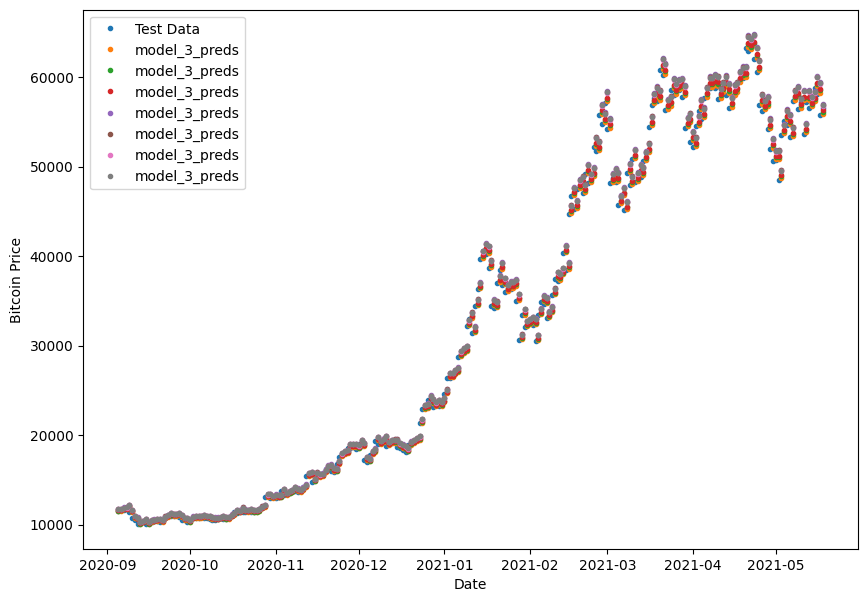

In [219]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series_data(X_test[-len(test_windows):], test_labels[:, 0], start=offset, label="Test Data")
plot_time_series_data(X_test[-len(test_windows):], model_3_preds, start=offset, label="model_3_preds")

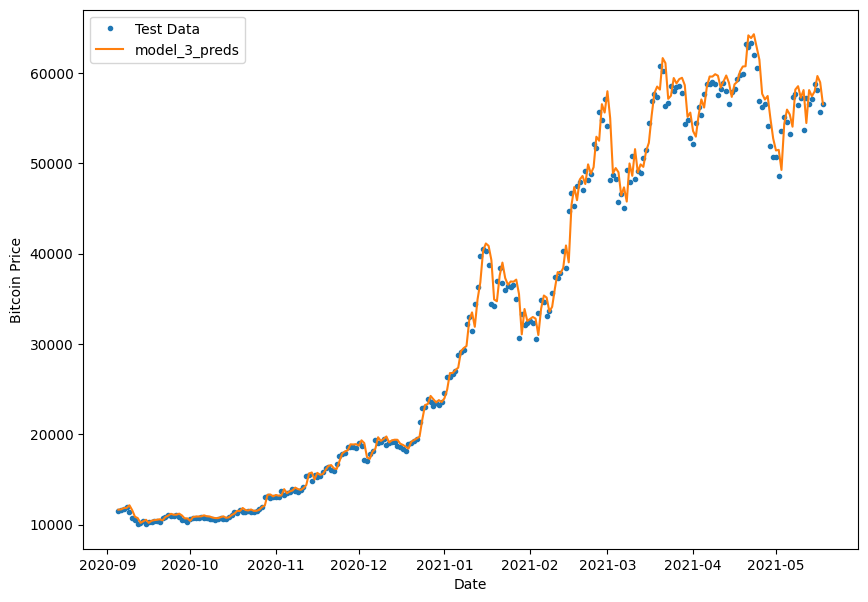

In [220]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series_data(X_test[-len(test_windows):], test_labels[:, 0], start=offset, label="Test Data")
plot_time_series_data(X_test[-len(test_windows):], tf.reduce_mean(model_3_preds, axis=-1), start=offset, label="model_3_preds", format="-")

In [221]:
model_3_preds[0]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([9316.699, 9362.177, 9382.705, 9502.049, 9487.626, 9475.177,
       9482.352], dtype=float32)>

In [222]:
tf.reduce_mean(model_3_preds, axis=-1)[0]

<tf.Tensor: shape=(), dtype=float32, numpy=9429.826>

In [223]:
sum([9389.02 , 9369.591, 9320.789, 9478.235, 9321.   , 9523.572,
       9474.47 ]) / 7

9410.953857142857

## Which model is performing the best so far?

So far we have trained a few models, now let's compare them and see how they have gone.

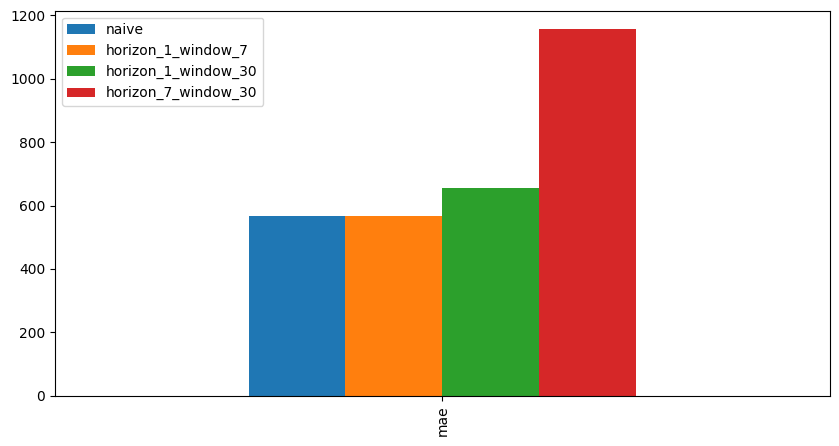

In [224]:
all_model_results = pd.DataFrame({"naive": naive_results["mae"],
                                  "horizon_1_window_7": model_1_results["mae"],
                                  "horizon_1_window_30": model_2_results["mae"],
                                  "horizon_7_window_30": model_3_results["mae"]}, index=["mae"])
all_model_results.plot(figsize=(10, 5), kind="bar");

## Model 4: Conv1D

In [225]:
HORIZON = 1 # Predict the next day ob bitcoin prices
WINDOW_SIZE = 7 # Use previous week worth data

In [226]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
full_windows.shape, full_labels.shape

((2780, 7), (2780, 1))

In [227]:
# Create train and test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)


  Training data : (2224, 7), (2224, 1)

  Test data: (556, 7), (556, 1)
  


**To use the Conv1D layer we need input shape of this:** `(batch_size, timesteps, input_dim...)`.

However our data isn't in that shape yet.

In [228]:
# Check data input_shape
train_windows[0].shape

(7,)

In [229]:
# Before we pass our data to Conv1D layer we have to reshape it in order to make sure that it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ], dtype=float32)>

In [230]:
expand_dims_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))
# Test our lambda layer
print(f"""
Original shape: {x.shape},\n
Expanded shape: {expand_dims_layer(x).shape}\n
Original values after expanding layer:\n {expand_dims_layer(x)}
      """)


Original shape: (7,),

Expanded shape: (7, 1)

Original values after expanding layer:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]
      


In [231]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()

model_4 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding="causal",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(HORIZON)
], name="model_4_Conv1D")
# Compile the model
model_4.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])
# Fit the model
history_4 = model_4.fit(train_windows, train_labels, epochs=100,
                        validation_data=(test_windows, test_labels),
                        callbacks=[create_model_checkpoint(model_4.name)],
                        verbose=0, batch_size=128)

In [232]:
model_4.summary()

Model: "model_4_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense (Dense)               (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [233]:
# Evaluate the last model (after 100 epochs)
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 578.4357 - mae: 578.4357


[578.4356689453125, 578.4356689453125]

In [234]:
# Load best model
model_4 = tf.keras.models.load_model("model_experiments/model_4_Conv1D")
# Evaluate the best model
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.9662 - mae: 568.9662


[568.9662475585938, 568.9662475585938]

In [235]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[0], model_4_preds.shape

18/18 [==============================] - 0s 2ms/step


(<tf.Tensor: shape=(), dtype=float32, numpy=8809.206>, TensorShape([556]))

In [236]:
model_4_results = evaluate_preds(tf.squeeze(test_labels), model_4_preds)
# Check model_4 results
model_4_results

{'mae': 568.96625,
 'mse': 1161108.8,
 'rmse': 1077.5476,
 'mape': 2.5655327,
 'mase': 0.9995161}

## Model 5: RNN (LSTM)

In [237]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()

inputs = tf.keras.layers.Input(shape=[WINDOW_SIZE])
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = tf.keras.layers.LSTM(units=128, return_sequences=True)(x)
x = tf.keras.layers.LSTM(units=128, activation="relu")(x)
x = tf.keras.layers.Dense(32, activation="relu",
                          kernel_initializer="he_normal")(x)
outputs = tf.keras.layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_LSTM")

# Compile the model
model_5.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])
# Train a model
history_5 = model_5.fit(train_windows, train_labels, epochs=100, batch_size=128,
                        validation_data=(test_windows, test_labels), verbose=1,
                        callbacks=[create_model_checkpoint(model_5.name)])

Epoch 1/100
16/18 [=========================>....] - ETA: 0s - loss: 1268.4949 - mae: 1268.4949

18/18 [==============================] - 5s 193ms/step - loss: 1187.0072 - mae: 1187.0072 - val_loss: 2035.1243 - val_mae: 2035.1243
Epoch 2/100
16/18 [=========================>....] - ETA: 0s - loss: 264.0506 - mae: 264.0506

18/18 [==============================] - 4s 242ms/step - loss: 252.5825 - mae: 252.5825 - val_loss: 902.7482 - val_mae: 902.7482
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 169.4605 - mae: 169.4605

18/18 [==============================] - 3s 156ms/step - loss: 169.4605 - mae: 169.4605 - val_loss: 884.2776 - val_mae: 884.2776
Epoch 4/100
14/18 [======================>.......] - ETA: 0s - loss: 167.6785 - mae: 167.6785

18/18 [==============================] - 3s 159ms/step - loss: 163.7733 - mae: 163.7733 - val_loss: 873.8069 - val_mae: 873.8069
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 159.8289 - mae: 159.8289 - val_loss: 903.1744 - val_mae: 903.1744
Epoch 6/100
18/18 [==============================] - 0s 9ms/step - loss: 151.5930 - mae: 151.5930 - val_loss: 913.0466 - val_mae: 913.0466
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 146.6583 - mae: 146.6583 - val_loss: 1044.3496 - val_mae: 1044.3496
Epoch 8/100
17/18 [===========================>..] - ETA: 0s - loss: 152.2054 - mae: 152.2054

18/18 [==============================] - 3s 184ms/step - loss: 151.8560 - mae: 151.8560 - val_loss: 769.7055 - val_mae: 769.7055
Epoch 9/100
18/18 [==============================] - 0s 16ms/step - loss: 138.0691 - mae: 138.0691 - val_loss: 772.7018 - val_mae: 772.7018
Epoch 10/100
18/18 [==============================] - 0s 18ms/step - loss: 136.1547 - mae: 136.1547 - val_loss: 796.2375 - val_mae: 796.2375
Epoch 11/100
18/18 [==============================] - 0s 15ms/step - loss: 145.2588 - mae: 145.2588 - val_loss: 818.8511 - val_mae: 818.8511
Epoch 12/100
18/18 [==============================] - 0s 17ms/step - loss: 142.8687 - mae: 142.8687 - val_loss: 789.1559 - val_mae: 789.1559
Epoch 13/100
18/18 [==============================] - 0s 19ms/step - loss: 143.2094 - mae: 143.2094 - val_loss: 834.2074 - val_mae: 834.2074
Epoch 14/100
18/18 [==============================] - 0s 10ms/step - loss: 139.7968 - mae: 139.7968 - val_loss: 823.6500 - val_mae: 823.6500
Epoch 15/100
18/18 [======

18/18 [==============================] - 3s 160ms/step - loss: 133.7945 - mae: 133.7945 - val_loss: 767.1056 - val_mae: 767.1055
Epoch 19/100
16/18 [=========================>....] - ETA: 0s - loss: 128.8796 - mae: 128.8796

18/18 [==============================] - 4s 222ms/step - loss: 128.9688 - mae: 128.9688 - val_loss: 750.1443 - val_mae: 750.1443
Epoch 20/100
16/18 [=========================>....] - ETA: 0s - loss: 127.5799 - mae: 127.5799

18/18 [==============================] - 3s 177ms/step - loss: 127.9712 - mae: 127.9712 - val_loss: 710.7170 - val_mae: 710.7170
Epoch 21/100
18/18 [==============================] - 0s 19ms/step - loss: 132.5784 - mae: 132.5784 - val_loss: 745.9302 - val_mae: 745.9302
Epoch 22/100
18/18 [==============================] - ETA: 0s - loss: 124.9138 - mae: 124.9138

18/18 [==============================] - 3s 202ms/step - loss: 124.9138 - mae: 124.9138 - val_loss: 678.7707 - val_mae: 678.7707
Epoch 23/100
17/18 [===========================>..] - ETA: 0s - loss: 123.4877 - mae: 123.4877

18/18 [==============================] - 3s 157ms/step - loss: 124.7666 - mae: 124.7666 - val_loss: 670.5945 - val_mae: 670.5945
Epoch 24/100
15/18 [========================>.....] - ETA: 0s - loss: 124.3880 - mae: 124.3880

18/18 [==============================] - 3s 161ms/step - loss: 123.7116 - mae: 123.7116 - val_loss: 669.4204 - val_mae: 669.4204
Epoch 25/100
17/18 [===========================>..] - ETA: 0s - loss: 122.1503 - mae: 122.1503

18/18 [==============================] - 4s 219ms/step - loss: 121.6832 - mae: 121.6832 - val_loss: 661.7795 - val_mae: 661.7795
Epoch 26/100
16/18 [=========================>....] - ETA: 0s - loss: 123.0999 - mae: 123.0999

18/18 [==============================] - 3s 188ms/step - loss: 121.1298 - mae: 121.1298 - val_loss: 649.1839 - val_mae: 649.1839
Epoch 27/100
10/18 [===============>..............] - ETA: 0s - loss: 122.1464 - mae: 122.1464

18/18 [==============================] - 2s 146ms/step - loss: 123.4149 - mae: 123.4149 - val_loss: 647.6193 - val_mae: 647.6193
Epoch 28/100
17/18 [===========================>..] - ETA: 0s - loss: 120.2034 - mae: 120.2034

18/18 [==============================] - 3s 155ms/step - loss: 120.2194 - mae: 120.2194 - val_loss: 639.9698 - val_mae: 639.9698
Epoch 29/100
18/18 [==============================] - 0s 11ms/step - loss: 117.6246 - mae: 117.6246 - val_loss: 656.8088 - val_mae: 656.8088
Epoch 30/100
17/18 [===========================>..] - ETA: 0s - loss: 125.7676 - mae: 125.7676

18/18 [==============================] - 3s 159ms/step - loss: 125.3098 - mae: 125.3098 - val_loss: 636.0293 - val_mae: 636.0293
Epoch 31/100
17/18 [===========================>..] - ETA: 0s - loss: 117.7352 - mae: 117.7352

18/18 [==============================] - 4s 251ms/step - loss: 118.2200 - mae: 118.2200 - val_loss: 629.6992 - val_mae: 629.6992
Epoch 32/100
17/18 [===========================>..] - ETA: 0s - loss: 119.4722 - mae: 119.4722

18/18 [==============================] - 3s 162ms/step - loss: 119.1861 - mae: 119.1861 - val_loss: 628.8546 - val_mae: 628.8546
Epoch 33/100
18/18 [==============================] - 0s 10ms/step - loss: 121.1260 - mae: 121.1260 - val_loss: 631.0933 - val_mae: 631.0933
Epoch 34/100
18/18 [==============================] - 0s 11ms/step - loss: 119.0130 - mae: 119.0130 - val_loss: 633.8993 - val_mae: 633.8993
Epoch 35/100
17/18 [===========================>..] - ETA: 0s - loss: 116.7821 - mae: 116.7821

18/18 [==============================] - 3s 160ms/step - loss: 116.6750 - mae: 116.6750 - val_loss: 622.4605 - val_mae: 622.4605
Epoch 36/100
15/18 [========================>.....] - ETA: 0s - loss: 118.8428 - mae: 118.8428

18/18 [==============================] - 3s 176ms/step - loss: 120.0923 - mae: 120.0923 - val_loss: 620.4884 - val_mae: 620.4884
Epoch 37/100
18/18 [==============================] - 0s 19ms/step - loss: 116.2689 - mae: 116.2689 - val_loss: 624.0074 - val_mae: 624.0074
Epoch 38/100
18/18 [==============================] - ETA: 0s - loss: 115.8303 - mae: 115.8303

18/18 [==============================] - 3s 202ms/step - loss: 115.8303 - mae: 115.8303 - val_loss: 613.8012 - val_mae: 613.8012
Epoch 39/100
17/18 [===========================>..] - ETA: 0s - loss: 115.8140 - mae: 115.8140

18/18 [==============================] - 3s 197ms/step - loss: 116.1860 - mae: 116.1860 - val_loss: 613.4412 - val_mae: 613.4412
Epoch 40/100
18/18 [==============================] - 0s 10ms/step - loss: 116.3407 - mae: 116.3407 - val_loss: 647.3081 - val_mae: 647.3081
Epoch 41/100
17/18 [===========================>..] - ETA: 0s - loss: 116.0564 - mae: 116.0564

18/18 [==============================] - 3s 162ms/step - loss: 115.0992 - mae: 115.0992 - val_loss: 612.1252 - val_mae: 612.1252
Epoch 42/100
18/18 [==============================] - 0s 11ms/step - loss: 117.4973 - mae: 117.4973 - val_loss: 693.3458 - val_mae: 693.3458
Epoch 43/100
18/18 [==============================] - 0s 11ms/step - loss: 121.6982 - mae: 121.6982 - val_loss: 649.7189 - val_mae: 649.7189
Epoch 44/100
18/18 [==============================] - 0s 10ms/step - loss: 122.1564 - mae: 122.1564 - val_loss: 626.5278 - val_mae: 626.5278
Epoch 45/100
18/18 [==============================] - 0s 10ms/step - loss: 116.5708 - mae: 116.5708 - val_loss: 621.0625 - val_mae: 621.0625
Epoch 46/100
15/18 [========================>.....] - ETA: 0s - loss: 119.7059 - mae: 119.7059

18/18 [==============================] - 3s 186ms/step - loss: 116.4080 - mae: 116.4080 - val_loss: 600.4980 - val_mae: 600.4980
Epoch 47/100
18/18 [==============================] - 0s 15ms/step - loss: 115.7927 - mae: 115.7927 - val_loss: 655.0521 - val_mae: 655.0521
Epoch 48/100
18/18 [==============================] - 0s 16ms/step - loss: 114.1373 - mae: 114.1373 - val_loss: 601.1253 - val_mae: 601.1253
Epoch 49/100
18/18 [==============================] - 0s 15ms/step - loss: 113.6438 - mae: 113.6438 - val_loss: 667.9694 - val_mae: 667.9694
Epoch 50/100
18/18 [==============================] - 0s 18ms/step - loss: 120.7189 - mae: 120.7189 - val_loss: 615.3344 - val_mae: 615.3344
Epoch 51/100
18/18 [==============================] - 0s 10ms/step - loss: 115.8919 - mae: 115.8919 - val_loss: 606.0899 - val_mae: 606.0899
Epoch 52/100
18/18 [==============================] - 0s 10ms/step - loss: 116.1231 - mae: 116.1231 - val_loss: 657.2004 - val_mae: 657.2004
Epoch 53/100
18/18 [=====

18/18 [==============================] - 5s 288ms/step - loss: 114.8459 - mae: 114.8459 - val_loss: 596.9061 - val_mae: 596.9061
Epoch 56/100
18/18 [==============================] - 0s 12ms/step - loss: 111.1901 - mae: 111.1901 - val_loss: 778.1096 - val_mae: 778.1096
Epoch 57/100
18/18 [==============================] - 0s 16ms/step - loss: 126.6138 - mae: 126.6138 - val_loss: 719.7786 - val_mae: 719.7786
Epoch 58/100
18/18 [==============================] - 0s 11ms/step - loss: 119.2831 - mae: 119.2831 - val_loss: 603.1406 - val_mae: 603.1406
Epoch 59/100
18/18 [==============================] - 0s 17ms/step - loss: 111.8861 - mae: 111.8861 - val_loss: 601.4976 - val_mae: 601.4976
Epoch 60/100
18/18 [==============================] - 0s 19ms/step - loss: 111.2489 - mae: 111.2489 - val_loss: 605.5305 - val_mae: 605.5305
Epoch 61/100
18/18 [==============================] - ETA: 0s - loss: 110.4441 - mae: 110.4441

18/18 [==============================] - 8s 489ms/step - loss: 110.4441 - mae: 110.4441 - val_loss: 593.4545 - val_mae: 593.4545
Epoch 62/100
13/18 [====================>.........] - ETA: 0s - loss: 109.6903 - mae: 109.6903

18/18 [==============================] - 8s 498ms/step - loss: 109.4614 - mae: 109.4614 - val_loss: 590.9307 - val_mae: 590.9307
Epoch 63/100
18/18 [==============================] - 1s 29ms/step - loss: 110.0603 - mae: 110.0603 - val_loss: 592.1783 - val_mae: 592.1783
Epoch 64/100
14/18 [======================>.......] - ETA: 0s - loss: 111.0099 - mae: 111.0099

18/18 [==============================] - 5s 274ms/step - loss: 111.5006 - mae: 111.5006 - val_loss: 589.3579 - val_mae: 589.3579
Epoch 65/100
18/18 [==============================] - 0s 10ms/step - loss: 111.6658 - mae: 111.6658 - val_loss: 598.5322 - val_mae: 598.5322
Epoch 66/100
18/18 [==============================] - 0s 10ms/step - loss: 109.9171 - mae: 109.9171 - val_loss: 600.5994 - val_mae: 600.5994
Epoch 67/100
18/18 [==============================] - 0s 10ms/step - loss: 110.8849 - mae: 110.8849 - val_loss: 700.1279 - val_mae: 700.1279
Epoch 68/100
18/18 [==============================] - 0s 10ms/step - loss: 115.3273 - mae: 115.3273 - val_loss: 669.8721 - val_mae: 669.8721
Epoch 69/100
16/18 [=========================>....] - ETA: 0s - loss: 119.1542 - mae: 119.1542

18/18 [==============================] - 7s 400ms/step - loss: 123.1465 - mae: 123.1465 - val_loss: 587.2617 - val_mae: 587.2617
Epoch 70/100
18/18 [==============================] - 0s 26ms/step - loss: 128.2012 - mae: 128.2012 - val_loss: 593.1540 - val_mae: 593.1540
Epoch 71/100
18/18 [==============================] - 0s 25ms/step - loss: 114.7508 - mae: 114.7508 - val_loss: 604.5670 - val_mae: 604.5670
Epoch 72/100
17/18 [===========================>..] - ETA: 0s - loss: 108.5695 - mae: 108.5695

18/18 [==============================] - 5s 284ms/step - loss: 110.6876 - mae: 110.6876 - val_loss: 584.9498 - val_mae: 584.9498
Epoch 73/100
18/18 [==============================] - 0s 9ms/step - loss: 110.8171 - mae: 110.8171 - val_loss: 586.9843 - val_mae: 586.9843
Epoch 74/100
18/18 [==============================] - 0s 11ms/step - loss: 112.2967 - mae: 112.2967 - val_loss: 596.8731 - val_mae: 596.8731
Epoch 75/100
18/18 [==============================] - 0s 10ms/step - loss: 110.2236 - mae: 110.2236 - val_loss: 586.2714 - val_mae: 586.2714
Epoch 76/100
17/18 [===========================>..] - ETA: 0s - loss: 110.5464 - mae: 110.5464

18/18 [==============================] - 3s 161ms/step - loss: 110.6208 - mae: 110.6208 - val_loss: 584.5440 - val_mae: 584.5440
Epoch 77/100
18/18 [==============================] - 0s 11ms/step - loss: 110.1776 - mae: 110.1776 - val_loss: 585.1111 - val_mae: 585.1111
Epoch 78/100
17/18 [===========================>..] - ETA: 0s - loss: 114.6705 - mae: 114.6705

18/18 [==============================] - 4s 217ms/step - loss: 113.7291 - mae: 113.7291 - val_loss: 583.4031 - val_mae: 583.4031
Epoch 79/100
18/18 [==============================] - 0s 18ms/step - loss: 110.5336 - mae: 110.5336 - val_loss: 600.3304 - val_mae: 600.3304
Epoch 80/100
18/18 [==============================] - 0s 19ms/step - loss: 108.8243 - mae: 108.8243 - val_loss: 596.7554 - val_mae: 596.7554
Epoch 81/100
18/18 [==============================] - 0s 18ms/step - loss: 108.5932 - mae: 108.5932 - val_loss: 586.7493 - val_mae: 586.7493
Epoch 82/100
18/18 [==============================] - 0s 16ms/step - loss: 115.6111 - mae: 115.6111 - val_loss: 599.4116 - val_mae: 599.4116
Epoch 83/100
18/18 [==============================] - 0s 18ms/step - loss: 116.0626 - mae: 116.0626 - val_loss: 625.7759 - val_mae: 625.7759
Epoch 84/100
18/18 [==============================] - 0s 15ms/step - loss: 114.4043 - mae: 114.4043 - val_loss: 608.6483 - val_mae: 608.6483
Epoch 85/100
18/18 [=====

18/18 [==============================] - 3s 163ms/step - loss: 107.3371 - mae: 107.3371 - val_loss: 579.8977 - val_mae: 579.8977
Epoch 96/100
18/18 [==============================] - 0s 11ms/step - loss: 114.6647 - mae: 114.6647 - val_loss: 654.7576 - val_mae: 654.7576
Epoch 97/100
18/18 [==============================] - 0s 11ms/step - loss: 111.2888 - mae: 111.2888 - val_loss: 592.3070 - val_mae: 592.3070
Epoch 98/100
18/18 [==============================] - 0s 10ms/step - loss: 107.5723 - mae: 107.5723 - val_loss: 590.1087 - val_mae: 590.1087
Epoch 99/100
17/18 [===========================>..] - ETA: 0s - loss: 108.3149 - mae: 108.3149

18/18 [==============================] - 3s 154ms/step - loss: 107.8402 - mae: 107.8402 - val_loss: 578.6406 - val_mae: 578.6406
Epoch 100/100
18/18 [==============================] - 0s 16ms/step - loss: 111.7987 - mae: 111.7987 - val_loss: 638.2321 - val_mae: 638.2321


In [238]:
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 638.2321 - mae: 638.2321


[638.2321166992188, 638.2321166992188]

In [239]:
# Load best performing model
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 1s 4ms/step - loss: 578.6406 - mae: 578.6406


[578.6405639648438, 578.6405639648438]

In [240]:
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 1s 10ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8886.435, 8779.452, 9022.453, 8802.897, 8724.647, 8761.511,
       8671.037, 8513.922, 8479.995, 8513.17 ], dtype=float32)>

In [241]:
model_5_results = evaluate_preds(tf.squeeze(test_labels), model_5_preds)
model_5_results

{'mae': 578.6405,
 'mse': 1196978.2,
 'rmse': 1094.0651,
 'mape': 2.583132,
 'mase': 1.0165111}

In [242]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

## Make a multivariate time series dataset

Before we add feature to our time series, what is a feature we can use?

How about bitcoin halving events?



In [243]:
# Let's make a multivariate time series
bitcoin_df.head()

,Price
Date,
2013-10-01,123.654991
2013-10-02,125.455002
2013-10-03,108.584831
2013-10-04,118.674660
2013-10-05,121.338661


In [244]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 may 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [245]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_df.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_df.index[0]).days
# Check if worked
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [246]:
# Add in block reward values as a feature to our dataframe
bitcon_prices_block = bitcoin_df.copy()
bitcon_prices_block["block_reward"] = None
# Add appropriate data
bitcon_prices_block.iloc[:block_reward_2_days, 1] = block_reward_2
bitcon_prices_block.iloc[block_reward_2_days:block_reward_3_days, 1] = block_reward_3
bitcon_prices_block.iloc[block_reward_3_days:, 1] = block_reward_4

bitcon_prices_block.head(), bitcon_prices_block.tail()

(                 Price block_reward
 Date                               
 2013-10-01  123.654991           25
 2013-10-02  125.455002           25
 2013-10-03  108.584831           25
 2013-10-04  118.674660           25
 2013-10-05  121.338661           25,
                    Price block_reward
 Date                                 
 2021-05-14  49764.132812         6.25
 2021-05-15  50032.691406         6.25
 2021-05-16  47885.625000         6.25
 2021-05-17  45604.617188         6.25
 2021-05-18  43144.472656         6.25)

In [247]:
# Plot the block reward vs price over time
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_bitcoin_prices_block = pd.DataFrame(scaler.fit_transform(bitcon_prices_block),
                                           columns=["Scaled price", "Scaled block reward"],
                                           index=bitcon_prices_block.index)
scaled_bitcoin_prices_block.head()

,Scaled price,Scaled block reward
Date,,
2013-10-01,0.000238,1.0
2013-10-02,0.000267,1.0
2013-10-03,0.000000,1.0
2013-10-04,0.000160,1.0
2013-10-05,0.000202,1.0


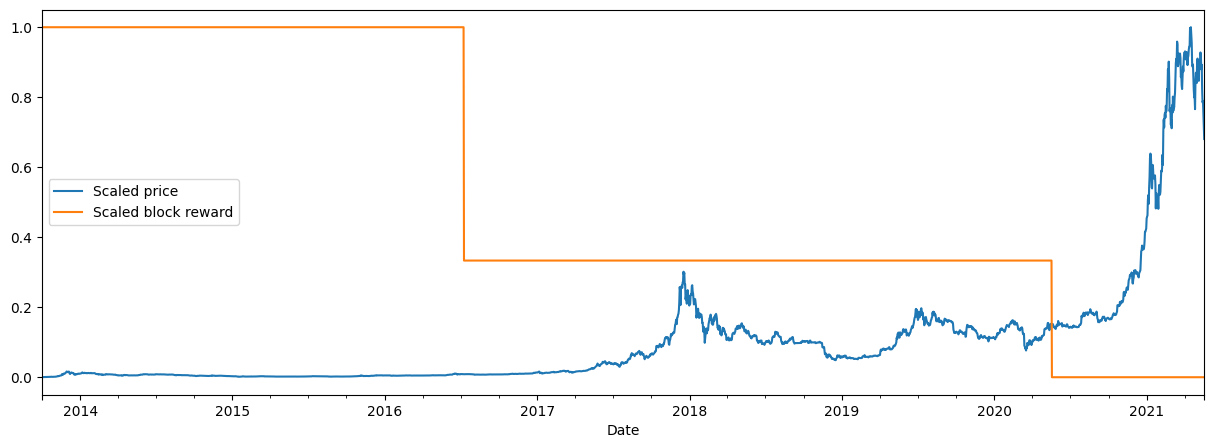

In [248]:
scaled_bitcoin_prices_block.plot(figsize=(15, 5))
plt.legend();

## Making a windowed dataset (with pandas)

Previously we turned our univariate time series into windowed dataset using the helper function above, however since we now have multivariate data this functions won't work.

But we can use pandas DataFrame's **shift()** method to window our multivariate data. DOCS: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html

In [249]:
# Setup dataset hyperparemters
HORIZON = 1
WINDOW_SIZE = 7

In [250]:
# Make a copy of bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcon_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for ech step in window_size
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.654991,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.455002,25,123.654991,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.584831,25,125.455002,123.654991,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.674660,25,108.584831,125.455002,123.654991,NaN,NaN,NaN,NaN
2013-10-05,121.338661,25,118.674660,108.584831,125.455002,123.654991,NaN,NaN,NaN
2013-10-06,120.655327,25,121.338661,118.674660,108.584831,125.455002,123.654991,NaN,NaN
2013-10-07,121.794998,25,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991,NaN
2013-10-08,123.032997,25,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,124.049004,25,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002


What we have done is created a way to window our dataset directly from pandas DataFrame.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [251]:
# Create X (windows) and y (horizon) features
X = bitcoin_prices_windowed.dropna().drop(columns=["Price"]).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

X.head(), y.head()

(            block_reward     Price+1     Price+2     Price+3     Price+4  \
 Date                                                                       
 2013-10-08          25.0  121.794998  120.655327  121.338661  118.674660   
 2013-10-09          25.0  123.032997  121.794998  120.655327  121.338661   
 2013-10-10          25.0  124.049004  123.032997  121.794998  120.655327   
 2013-10-11          25.0  125.961159  124.049004  123.032997  121.794998   
 2013-10-12          25.0  125.279663  125.961159  124.049004  123.032997   
 
                Price+5     Price+6     Price+7  
 Date                                            
 2013-10-08  108.584831  125.455002  123.654991  
 2013-10-09  118.674660  108.584831  125.455002  
 2013-10-10  121.338661  118.674660  108.584831  
 2013-10-11  120.655327  121.338661  118.674660  
 2013-10-12  121.794998  120.655327  121.338661  ,
 Date
 2013-10-08    123.032997
 2013-10-09    124.049004
 2013-10-10    125.961159
 2013-10-11    125.27966

In [252]:
# Make train and test sets using indexing
split_size = int(0.8 * len(X))
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

# Check the shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2224, 8), (556, 8), (2224,), (556,))

## Model 6: Dense (multivariate time series)

In [253]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(HORIZON)
], name="model_6_dense_multivariate")
# Compile the model
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())
# Fit the model
history_6 = model_6.fit(X_train, y_train, epochs=100, verbose=0,
                        validation_data=(X_test, y_test),
                        batch_size=128,
                        callbacks=[create_model_checkpoint(model_6.name)])

In [254]:
model_6.summary()

Model: "model_6_dense_multivariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               1152      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [255]:
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 645.5229


645.5228881835938

In [256]:
# Load best model
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 570.6782


570.6781616210938

In [257]:
model_6_preds = make_preds(model_6, X_test)
model_6_results = evaluate_preds(y_test, model_6_preds)
model_6_results

18/18 [==============================] - 0s 1ms/step


{'mae': 570.67816,
 'mse': 1158426.8,
 'rmse': 1076.3024,
 'mape': 2.594878,
 'mase': 1.0025234}

In [258]:
model_1_results

{'mae': 565.9127,
 'mse': 1161480.8,
 'rmse': 1077.7202,
 'mape': 2.5482464,
 'mase': 0.9941519}

# Model 7: N-BEATS algorithm

Let's try now build the biggest time forecasting model so far. We are going to be replicating model from the following paper: https://arxiv.org/abs/1905.10437.

## Building and testing the N-BEATS block layer

Beacuse the N-beats block layer doesn't exist in TensorFlow, we have to create it. To create custom layers in TensorFlow we can use **subclassing**.

In [259]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu",
                                         kernel_initializer="he_normal") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

**Let's test our N-beats block class.**

To do it we will make some dummy inputs and outputs.

In [260]:
WINDOW_SIZE = 7
HORIZON = 1

In [261]:
# Setup dummy NBeatsBlock layer to represent inputs and outputs of this layer
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON, n_neurons=512, n_layers=4)

In [262]:
# Create dummy inputs (have to be the same size as input size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE), axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6]], dtype=int32)>

In [263]:
# Pass dummy inputs through our custom layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# View results, they are going to be random since our layer is not trained yet
print(f"Backcast: {backcast}\nForecast: {forecast}")

Backcast: [[ 0.16666374 -2.9473004  -2.021655   -7.84268     7.1842356  -9.162683
  -0.21744609]]
Forecast: [[1.3599164]]


## Preparing data for the N-Beats algorithm using tf.data

To make our input data load as fast as possible we are going to be adhering to the performant data pipeline steps in the `tf.data` guide.

In [264]:
HORIZON = 1
WINDOW_SIZE = 7

In [265]:
# Create NBEATS data inputs (N-BEATS works with univariate time series)
bitcoin_df.head()

,Price
Date,
2013-10-01,123.654991
2013-10-02,125.455002
2013-10-03,108.584831
2013-10-04,118.674660
2013-10-05,121.338661


In [266]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_df.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(i+1)

bitcoin_prices_nbeats.head(10)

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.654991,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.455002,123.654991,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.584831,125.455002,123.654991,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.674660,108.584831,125.455002,123.654991,NaN,NaN,NaN,NaN
2013-10-05,121.338661,118.674660,108.584831,125.455002,123.654991,NaN,NaN,NaN
2013-10-06,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991,NaN,NaN
2013-10-07,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991,NaN
2013-10-08,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002


In [267]:
# Makes features (X) and labels (y)
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]
# Check features and labels
X.head()

,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,
2013-10-08,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [268]:
X.shape, y.shape

((2780, 7), (2780,))

In [269]:
split_size = int(0.8 * len(X))
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
# Check the shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2224, 7), (556, 7), (2224,), (556,))

### Creating efficient pipelines using tf.data API

In [270]:
# set some global variables that are going to be useful later
BATCH_SIZE = 1024
AUTOTUNE = tf.data.AUTOTUNE

In [271]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X_train),
                                                    tf.constant(y_train))).cache()
test_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X_test),
                                                    tf.constant(y_test))).cache()
# Turn them into batches and prefetch them
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
# Check if worked
train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

### Setup hyperparamters for N-BEATS algorithm

The N-BEATS algorithm has a lot of parameters, most of them can be found in table 18 in the original paper: https://arxiv.org/pdf/1905.10437.pdf.

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of the original paper).

In [272]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before we can craft our N-BEATS model, we need two layers for the residual connections (substract and add).

In [273]:
a, b = tf.range(5), tf.range(5)
added = tf.keras.layers.add([a, b])
subtracted = tf.keras.layers.subtract([a, b])

added, subtracted

(<tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 2, 4, 6, 8], dtype=int32)>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 0, 0, 0, 0], dtype=int32)>)


### Building, compiling and fitting the N-BEATS algorithm

In [340]:
%%time

from tensorflow.keras import layers

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

In [339]:
# Evaluate NBeats algorithm
model_7.evaluate(test_dataset)

In [338]:
model_7_preds = model_7.predict(test_dataset)
model_7_preds[:10]

In [337]:
model_7_preds = tf.squeeze(model_7_preds)
model_7_preds[:10]

In [336]:
model_7_results = evaluate_preds(y_test, model_7_preds)
model_7_results

In [279]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

### Plotting the N-Beats architecture we have created

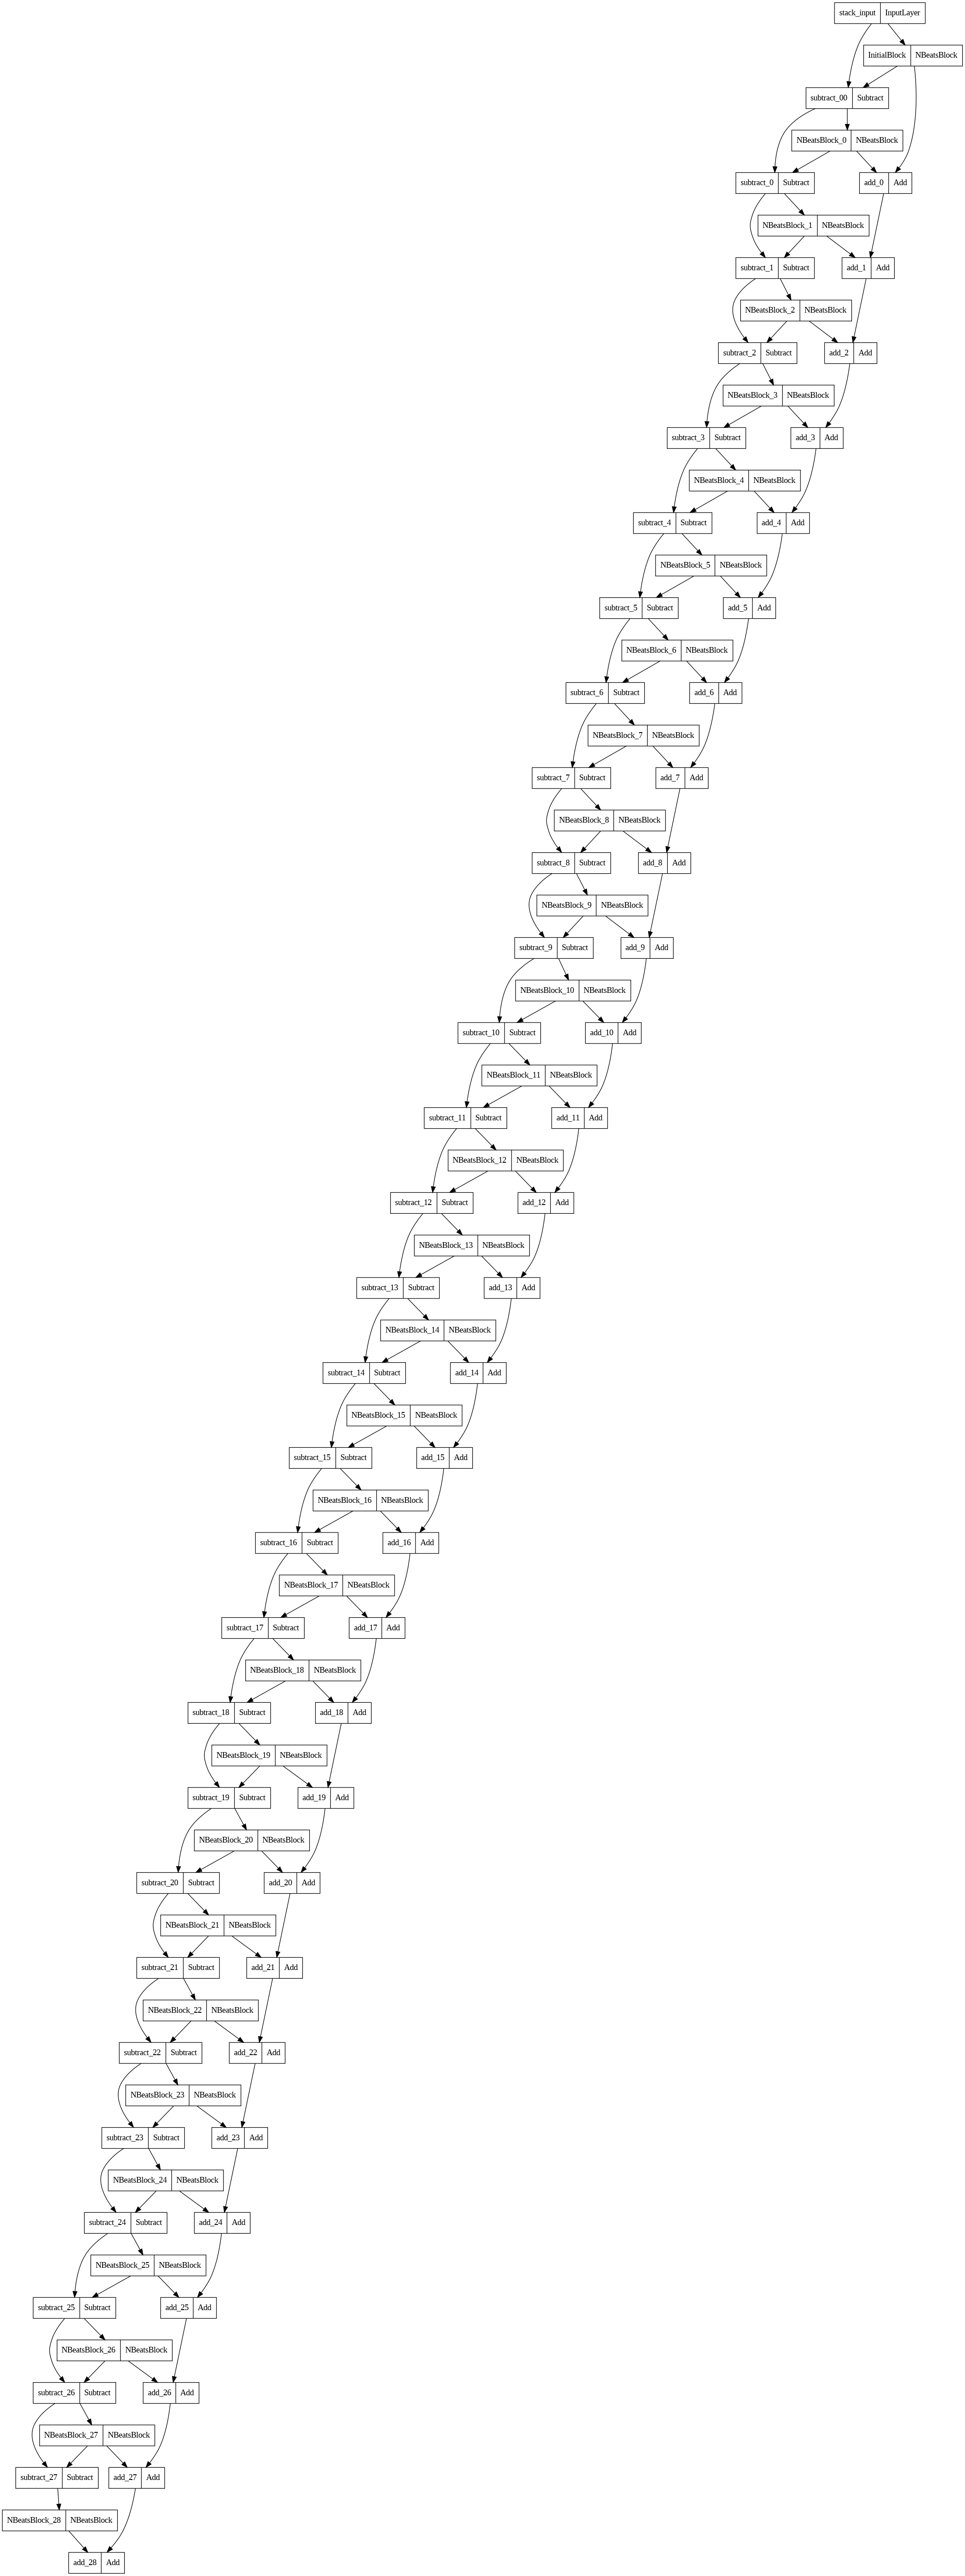

In [280]:
# Plot the N-BEATS model and inspect it's architecture
tf.keras.utils.plot_model(model_7)

# Model 8: ensemble (stacking multiple models together)

An ensemble leverages wisdom of the crowd effect. We combine many different models to make final predictions.

### Constructing and fitting an ensemble of models (using different loss functions)

In [281]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models, each trained on MAE, MSE, MAPE losses.
  If num_iter=10, we will return 30 different trained models.
  """
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          tf.keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal"),
          tf.keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal"),
          tf.keras.layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      # Fit the model
      model.fit(train_data,
                epochs=num_epochs,
                validation_data=(test_data),
                verbose=0,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])
      # Append trained model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [282]:
%%time

ensemble_models = get_ensemble_models(num_iter=5, num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 830: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 291: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 133: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 146: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 313: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mape for 1000 epochs, model number: 1

Epoch 113: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mae for 1000 epochs, model number: 2
Optimizing model by reducing: mse for 1000 epochs

In [283]:
# Check our trained models
ensemble_models

## Make predictions with our ensemble models

In [284]:
# Create a function to make predictions using our ensemble models
def make_ensemble_preds(models, data):
  ensemble_preds = []
  for model in models:
    model_preds = model.predict(data, verbose=0)
    ensemble_preds.append(model_preds)

  return tf.constant(tf.squeeze(ensemble_preds))

In [285]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models,
                                     test_dataset)
ensemble_preds

<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8818.661,  8780.552,  9077.86 , ..., 49838.055, 49393.023,
        47246.65 ],
       [ 8779.729,  8743.986,  9103.079, ..., 51279.32 , 47540.06 ,
        46307.895],
       [ 8889.827,  8908.192,  9248.695, ..., 50520.58 , 49479.402,
        46163.92 ],
       ...,
       [ 8866.809,  8861.043,  9080.553, ..., 49753.117, 48153.977,
        45736.68 ],
       [ 8794.507,  8788.288,  9008.813, ..., 49996.336, 48100.605,
        46951.35 ],
       [ 9171.383,  9161.529,  9420.025, ..., 51598.734, 50051.58 ,
        47623.816]], dtype=float32)>

In [286]:
ensemble_results = evaluate_preds(y_test,
                                  ensemble_preds)
ensemble_results

{'mae': 709.0308,
 'mse': 1744467.5,
 'rmse': 1275.0521,
 'mape': 3.285296,
 'mase': 1.2455705}

In [287]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10], ensemble_mean.shape

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8928.954, 8901.988, 9117.649, 8810.838, 8834.353, 8820.207,
        8710.527, 8598.9  , 8544.742, 8585.868], dtype=float32)>,
 TensorShape([556]))

In [288]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:5], ensemble_median.shape

(array([8818.661, 8788.288, 9066.353, 8759.366, 8751.811], dtype=float32),
 (556,))

In [289]:
ensemble_results_mean = evaluate_preds(y_test,
                                  ensemble_mean)
ensemble_results_mean

{'mae': 596.67224,
 'mse': 1258125.5,
 'rmse': 1121.662,
 'mape': 2.695735,
 'mase': 1.0481879}

In [290]:
ensemble_results_median = evaluate_preds(y_test,
                                         ensemble_median)
ensemble_results_median

{'mae': 578.8797,
 'mse': 1181492.1,
 'rmse': 1086.9646,
 'mape': 2.5935926,
 'mase': 1.0169313}

In [291]:
ensemble_results = ensemble_results_median
ensemble_results

{'mae': 578.8797,
 'mse': 1181492.1,
 'rmse': 1086.9646,
 'mape': 2.5935926,
 'mase': 1.0169313}

## Plotting the prediction intervals (uncertainty estimates) of our ensemble

So far we have been making point predictions with our models.

It would be helpful if we knew the range of where that predictions came from.

Instead of predicting single number (just one dot) like 50000, we can predict 48000 - 52000.

One way to get the 95% confidence prediction intervals for a deep learning is a bootstrap method:

1. Take the predictions from a number of randomly initialized models (we got this, thanks to our ensemble models).
2. Measure the standard deviation of the predictions.
3. Multiply standard deviation by 1.96 (assuming our distribution of data is Gaussian/Normal, 95% of observations fall withing 1.96 standard deviations of the mean).
4. Get the prediction interval upper and lower bounds, add and substract the value obtained in (3) to the mean/median of the predictions made in one.


<img src="https://upload.wikimedia.org/wikipedia/commons/b/bf/NormalDist1.96.png" />

In [292]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1.
  """
  This function only makes sense, if we
  assume that our data is normally distributed.
  """
  # 2. Measure std
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply std by 1.96
  interval = 1.96 * std

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.math.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  print(f"Lower bound is: {lower[:5]}...\nUpper bound is: {upper[:5]}...")

  return lower, upper

In [293]:
# Get upper and lower bound of 95% prediction interval
lower, upper = get_upper_lower(ensemble_preds)

Lower bound is: [8468.564 8423.07  8711.913 8440.327 8342.526]...
Upper bound is: [9389.344 9380.906 9523.386 9181.349 9326.179]...


In [294]:
# Get the median/mean values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median.shape

(556,)

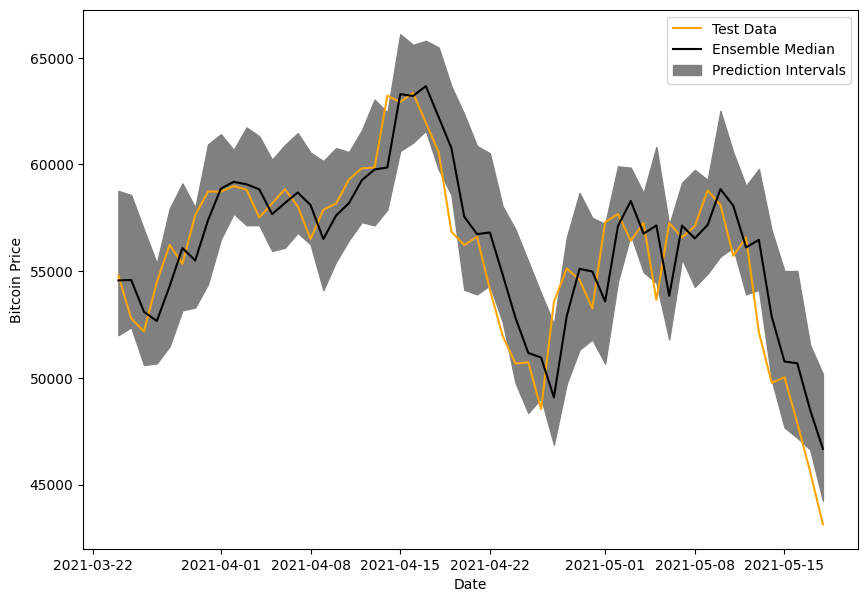

In [295]:
# Plot the median of our ensemble preds along with the prediction intervals
offset = 500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "orange", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
# Plot the upper and lower bound using matplotlib fill_between method
plt.fill_between(x=X_test.index[offset:], y1=lower[offset:], y2=upper[offset:], label="Prediction Intervals", color="gray")

plt.legend();

So far all of our models predictions have been lagging behind the test data. As if they were replicating what naive model does and just predicts the previous values as the next values.

> **Note:** these predictions intervals are estimates themselves, and they were created with the assumption that our data if from a normal distribution.

# Aside: two types of uncertainty (coconut and subway)

Uncertainty estimates in Machine Learning seek out to answer the question:

1. What can my model know? If we have perfect data, what is possible for our model to learn.
2. What doesn't my model know, what kind of things our model won't learn.

There are two major types of uncertainty in machine learning:

* **Aleatoric uncertainty** - this type of uncertainty can't be reduced, it is often referred as data uncertainty or subway uncertainty.
* **Epistemic uncertainty** - this type of uncertainty can be reduced, it is alos referred as model uncertainty or coconut uncertainty.



# Model 9: Train a model on full historical data to make predictions into the future

So fat all of our models made predictions on the test data, however this is only pseudo future. Now we are going to build a model to predict prices of bitcoin in the actual future. We will also have to prepare our datasets for this task.

In [296]:
HORIZON = 1
WINDOW_SIZE = 7

In [297]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.654991,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.455002,25,123.654991,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.584831,25,125.455002,123.654991,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.674660,25,108.584831,125.455002,123.654991,NaN,NaN,NaN,NaN
2013-10-05,121.338661,25,118.674660,108.584831,125.455002,123.654991,NaN,NaN,NaN


In [298]:
# Train model on entire dataset
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

# Check the shapes
X_all.shape, y_all.shape

((2780, 7), (2780,))

## Creating efficient data pipelines

In [299]:
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)
full_dataset = tf.data.Dataset.zip((features_dataset_all,
                                    labels_dataset_all)).batch(1024).prefetch(tf.data.AUTOTUNE)
# Check if our dataset is correctly prefetched
full_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [300]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()

model_9 = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(HORIZON)
], name="model_9_future")
# Compile the model
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())
# Train/Fit the model
history_9 = model_9.fit(full_dataset,
                        epochs=100,
                        verbose=0)

## Making predictions into the future

![flowchart representation prediction loop to make forecasts and then append forecasts to data and make more forecasts continuously until forecast horizon is exhausted](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-prediction-loop-for-forecasts.png)
*Example flow chart representing the loop we're about to create for making forecasts. Not pictured: retraining a forecasting model every time a forecast is made & new data is acquired. For example, if you're predicting the price of Bitcoin daily, you'd want to retrain your model every day, since each day you're going to have a new data point to work with.*

Alright, let's create a function which returns `INTO_FUTURE` forecasted values using a trained model.

To do so, we'll build the following steps:
1. Function which takes as input:
  * a list of values (the Bitcoin historical data)
  * a trained model (such as `model_9`)
  * a window into the future to predict (our `INTO_FUTURE` variable)
  * the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the function) and extracts the last `WINDOW_SIZE` values from the input values (predictions will start from the last `WINDOW_SIZE` values of the training data)
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` datasets which update to remove the first the value and append the latest prediction
  * Eventually future predictions will be made using the model's own previous predictions as input

In [301]:
INTO_FUTURE = 14

In [302]:
# We create a function to make predictions into the future
def make_future_forecast(values, model, into_future=INTO_FUTURE, window_size=WINDOW_SIZE):
  """
  Make future forecasts into_future steps after values ends.

  Returns future forecast as a list of floats.
  """
  # 2.
  future_forecasts = []
  last_window = values[-window_size:]
  fixed_window_length = len(last_window)

  # 3.
  for _ in range(into_future):
    # Predict on the last window and then append it again
    future_preds = model.predict(tf.expand_dims(last_window, axis=0), verbose=0)
    print(f"Predicting on:\n{last_window} -> Prediction: {tf.squeeze(future_preds).numpy()}\n")

    # Append predictions to future forecast
    future_forecasts.append(future_preds)

    # Update last window
    last_window = np.append(last_window, future_preds)[-WINDOW_SIZE:]
    assert len(last_window) == fixed_window_length

  return tf.squeeze(future_forecasts)

In [303]:
# Make forecasts into future
future_forecast = make_future_forecast(y_all,
                                       model_9)
future_forecast, len(future_forecast)

Predicting on:
[56573.555 52147.82  49764.133 50032.69  47885.625 45604.617 43144.473] -> Prediction: 53815.74609375

Predicting on:
[52147.82  49764.133 50032.69  47885.625 45604.617 43144.473 53815.746] -> Prediction: 48389.8203125

Predicting on:
[49764.133 50032.69  47885.625 45604.617 43144.473 53815.746 48389.82 ] -> Prediction: 51702.15234375

Predicting on:
[50032.69  47885.625 45604.617 43144.473 53815.746 48389.82  51702.152] -> Prediction: 50691.984375

Predicting on:
[47885.625 45604.617 43144.473 53815.746 48389.82  51702.152 50691.984] -> Prediction: 44563.24609375

Predicting on:
[45604.617 43144.473 53815.746 48389.82  51702.152 50691.984 44563.246] -> Prediction: 43790.13671875

Predicting on:
[43144.473 53815.746 48389.82  51702.152 50691.984 44563.246 43790.137] -> Prediction: 43654.00390625

Predicting on:
[53815.746 48389.82  51702.152 50691.984 44563.246 43790.137 43654.004] -> Prediction: 49034.25390625

Predicting on:
[48389.82  51702.152 50691.984 44563.246 437

(<tf.Tensor: shape=(14,), dtype=float32, numpy=
 array([53815.746, 48389.82 , 51702.152, 50691.984, 44563.246, 43790.137,
        43654.004, 49034.254, 48534.09 , 53059.086, 48860.77 , 43698.754,
        42191.117, 40816.32 ], dtype=float32)>,
 14)

## Plot future forecasts

In [304]:
np.datetime64('2005-01-01') + np.timedelta64(10, "D")

numpy.datetime64('2005-01-11')

In [305]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values ranging from start_date into future
  """
  start_date = start_date + np.timedelta64(offset, "D") # Specify start date
  end_data = start_date + np.timedelta64(into_future, "D") # Specify end date
  # Return date range between start and end date
  return np.arange(start_date, end_data, dtype="datetime64[D]")

In [306]:
last_time_step = bitcoin_prices_windowed.index[-1]
last_time_step, type(last_time_step)

(Timestamp('2021-05-18 00:00:00'), pandas._libs.tslibs.timestamps.Timestamp)

In [307]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(last_time_step, into_future=INTO_FUTURE)
next_time_steps, len(next_time_steps)

(array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
        '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
        '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
        '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 14)

Let's insert last timestep (final price) into next time steps and future forecasts so the plot doesn't look junky.

In [308]:
len(next_time_steps), len(future_forecast)

(14, 14)

In [309]:
next_time_steps = np.insert(next_time_steps, 0, last_time_step)
future_forecast = np.insert(future_forecast, 0, bitcoin_prices[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 53815.746, 48389.82 , 51702.152, 50691.984, 44563.246,
        43790.137, 43654.004, 49034.254, 48534.09 , 53059.086, 48860.77 ,
        43698.754, 42191.117, 40816.32 ], dtype=float32))

In [310]:
len(next_time_steps), len(future_forecast)

(15, 15)

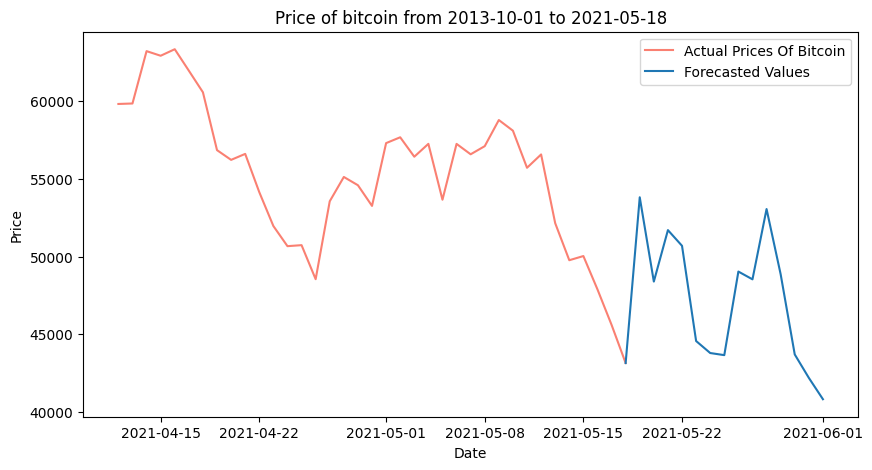

In [311]:
# Plot future price predictions of bitcoin
fig = plt.figure(figsize=(10, 5))

plt.plot(bitcoin_df.index[2750:], bitcoin_df["Price"][2750:], color="salmon", label="Actual Prices Of Bitcoin")
plt.xlabel("Date")
plt.title("Price of bitcoin from 2013-10-01 to 2021-05-18")
plt.ylabel("Price");
plt.plot(next_time_steps, future_forecast, label="Forecasted Values")

plt.legend();

# Model 10: why forecasting is BS (the turkey problem 🦃)

In [312]:
# Let's introduce the turkey problem to our BTC data (price of BTC falls 100x in one day)
btc_price_turkey = bitcoin_prices.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [313]:
# Manufacture an extra price on the end
btc_price_turkey[-10:]

array([58788.21   , 58102.19   , 55715.547  , 56573.555  , 52147.82   ,
       49764.133  , 50032.69   , 47885.625  , 45604.617  ,   431.44473],
      dtype=float32)

In [314]:
btc_timesteps_turkey = np.array(bitcoin_df.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

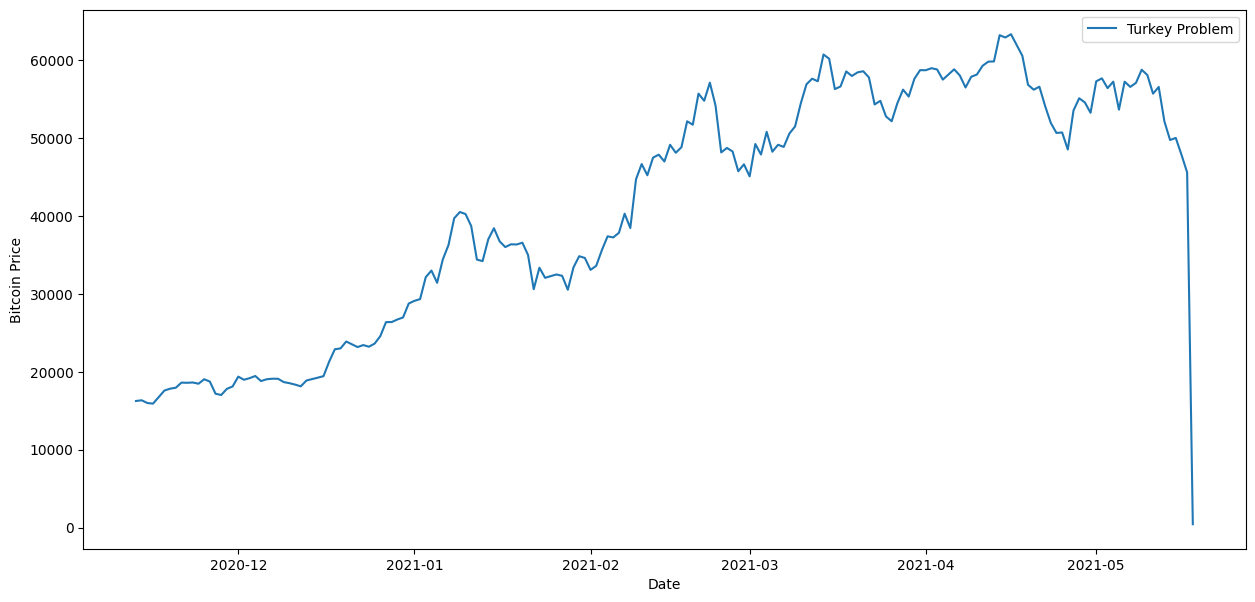

In [315]:
fig = plt.figure(figsize=(15, 7))
plot_time_series_data(btc_timesteps_turkey, btc_price_turkey, start=2600, label="Turkey Problem", format="-")

In [316]:
HORIZON = 1
WINDOW_SIZE = 7

In [317]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)


  Training data : (2224, 7), (2224, 1)

  Test data: (556, 7), (556, 1)
  


(2224, 556, 2224, 556)

In [318]:
model_10 = tf.keras.models.clone_model(model_1)
model_10._name = "Turkey_Model"
model_10.summary()

Model: "Turkey_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               1024      
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [319]:
model_10.compile(loss="mae",
                 optimizer=tf.keras.optimizers.Adam())
model_10.fit(X_train, y_train, epochs=100,
             validation_data=(X_test, y_test),
             batch_size=32,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True)],
             verbose=0)

In [320]:
model_10.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 646.0936


646.0936279296875

In [321]:
# Make predictions with Turkey model
turkey_preds = make_preds(model_10, X_test)
turkey_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8882.533, 8781.393, 9031.656, 8792.99 , 8737.758, 8756.591,
       8698.672, 8509.906, 8483.324, 8528.003], dtype=float32)>

In [322]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

{'mae': 17122.963,
 'mse': 613977400.0,
 'rmse': 23702.37,
 'mape': 121.27688,
 'mase': 26.497843}

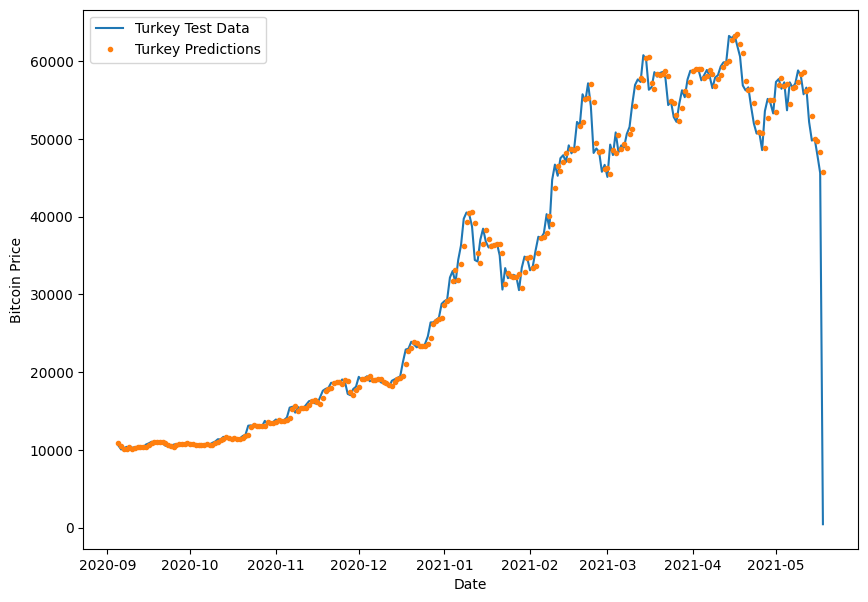

In [323]:
plt.figure(figsize=(10, 7))
offset = 300
plot_time_series_data(btc_timesteps_turkey[-len(X_test):], btc_price_turkey[-len(X_test):], start=offset, label="Turkey Test Data", format="-")
plot_time_series_data(btc_timesteps_turkey[-len(X_test):], turkey_preds, start=offset, label="Turkey Predictions")

# Compare models

In [331]:
# Compare different model results
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_conv1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_dense_multivariate": model_6_results,
                              "model_8_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T

model_results

,mae,mse,rmse,mape,mase
naive_model,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,565.912720,1.161481e+06,1077.720215,2.548246,0.994152
model_2_dense_w30_h1,656.006653,1.460278e+06,1208.419678,3.059410,1.146706
model_3_dense_w30_h7,1157.408813,4.787886e+06,1335.776855,5.278162,2.072468
model_4_conv1D,568.966248,1.161109e+06,1077.547607,2.565533,0.999516
model_5_LSTM,578.640503,1.196978e+06,1094.065063,2.583132,1.016511
model_6_dense_multivariate,570.678162,1.158427e+06,1076.302368,2.594878,1.002523
model_8_ensemble,578.879700,1.181492e+06,1086.964600,2.593593,1.016931
model_10_turkey,17122.962891,6.139774e+08,23702.369141,121.276878,26.497843


In [332]:
# Sort model results by MAE and plot them
model_results_mae = model_results["mae"].sort_values(ascending=False)
model_results_mae

model_10_turkey               17122.962891
model_3_dense_w30_h7           1157.408813
model_2_dense_w30_h1            656.006653
model_8_ensemble                578.879700
model_5_LSTM                    578.640503
model_6_dense_multivariate      570.678162
model_4_conv1D                  568.966248
naive_model                     567.980225
model_1_dense_w7_h1             565.912720
Name: mae, dtype: float32

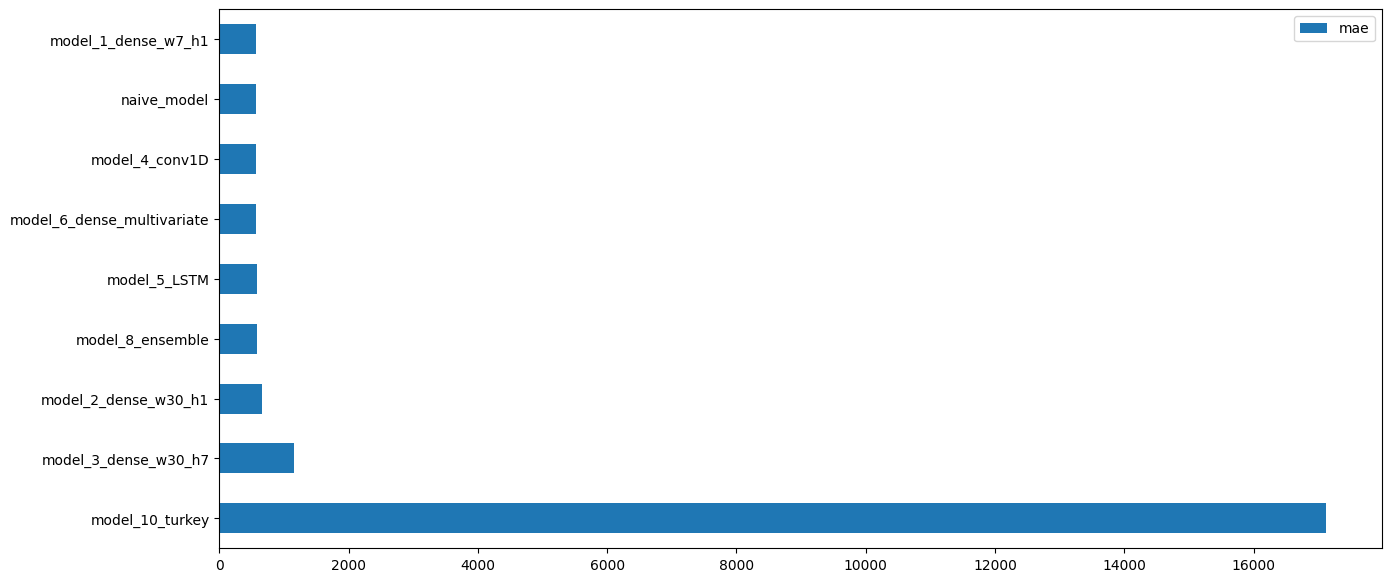

In [335]:
model_results_mae.plot(kind="barh", figsize=(15, 7))
plt.legend();